In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA

In [2]:
# Read the dataset
cleaned_df = pd.read_csv('/Users/priyakundu/Documents/NYU Capstone WaterVue Files/Data Processing/Updated_Dataframe_WaterQual.csv')
cleaned_df

Location Sample Date  Chlorophyll A  \
0          #1 HILLSBORO CANAL US 1  2006-02-28      12.100000   
1          #1 HILLSBORO CANAL US 1  2006-08-31       4.430000   
2          #1 HILLSBORO CANAL US 1  2007-02-28       2.605000   
3          #1 HILLSBORO CANAL US 1  2007-08-31       4.890000   
4          #1 HILLSBORO CANAL US 1  2008-02-29       5.925000   
..                             ...         ...            ...   
853  #89 NOB HILL RD POMPANO CANAL  2020-02-29       3.933333   
854  #89 NOB HILL RD POMPANO CANAL  2020-08-31       1.570000   
855  #89 NOB HILL RD POMPANO CANAL  2021-02-28       2.966667   
856  #89 NOB HILL RD POMPANO CANAL  2021-08-31       5.510000   
857  #89 NOB HILL RD POMPANO CANAL  2022-02-28       2.900000   

     Dissolved Oxygen   Salinity  Specific Conductance  Total Nitrogen  \
0            6.980000  19.400000             10.351373        0.830000   
1            5.540000  15.750000             10.165844        0.981000   
2            6.195000  23.200000             10.501905        0.754000   
3            4.730000  31.100000             10.774781        0.777000   
4            5.770000  12.500000              9.893361        1.440000   
..                ...        ...                   ...             ...   
853          5.703333   0.310000              6.451930        1.097133   
854          7.760000   0.250000              6.265301        0.910000   
855          5.833333   0.233333              6.153383        0.984033   
856          5.370000   0.270000              6.324359        1.410500   
857          4.940000   0.290000              6.388561        1.040000   

     Total Phosphorus  Turbidity  
0            0.086000   2.400000  
1            0.109000   1.400000  
2            0.083500   1.650000  
3            0.094000   2.300000  
4            0.102000   2.050000  
..                ...        ...  
853          0.014000   0.750000  
854          0.011000   0.000000  
855          0.003667   0.566667  
856          0.049000   0.775000  
857          0.008000   0.550000  

[858 rows x 9 columns]

In [3]:
sorted_df = cleaned_df.sort_values(by='Sample Date', ascending=True)

In [4]:
# Split data into train and test sets
train_data = sorted_df.iloc[:-3*cleaned_df["Location"].nunique()].sort_values(by=['Location', 'Sample Date'], ascending=True)  # Use all but the last 12 months for training
test_data = sorted_df.iloc[-3*cleaned_df["Location"].nunique():].sort_values(by=['Location', 'Sample Date'], ascending=True)   # Use the last 12 months for testing

## Chlorophyll A

In [5]:
param = 'Chlorophyll A'

In [6]:
predictions = []
for location in train_data["Location"].unique():
    train_df = train_data[train_data["Location"]==location]
    test_df = test_data[test_data["Location"]==location]

    # Fit ARIMA model
    order = (2, 1, 1)  # Example (p, d, q)
    model = ARIMA(train_df[param], order=order)
    result = model.fit()

    # Forecast future values
    forecast = result.get_forecast(steps=3)  # Forecasting next 1.5 years (6 biannual periods) into the future
    forecast_index = pd.date_range(start=train_df["Sample Date"].iloc[-1], periods=4, freq='6M')[1:]
    forecast_values = forecast.predicted_mean

    predictions.append(pd.DataFrame({"Location": [location]*3, "Sample Date": forecast_index,param: forecast_values}))
pred_data = pd.concat(predictions)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/var/folders/9n/nyfs9h7n2lsfs0vd2lq0589h0000gn/T/ipykernel_40936/3898892124.py:13: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=train_df["Sample Date"].iloc[-1], periods=4, freq='6M')[1:]
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was pr

In [7]:
# Concatenate train and test data for plotting
combined_data = pd.concat([train_data.assign(dataset='Train'), test_data.assign(dataset='Test'), pred_data.assign(dataset='Prediction')])

<Figure size 2000x1500 with 0 Axes>

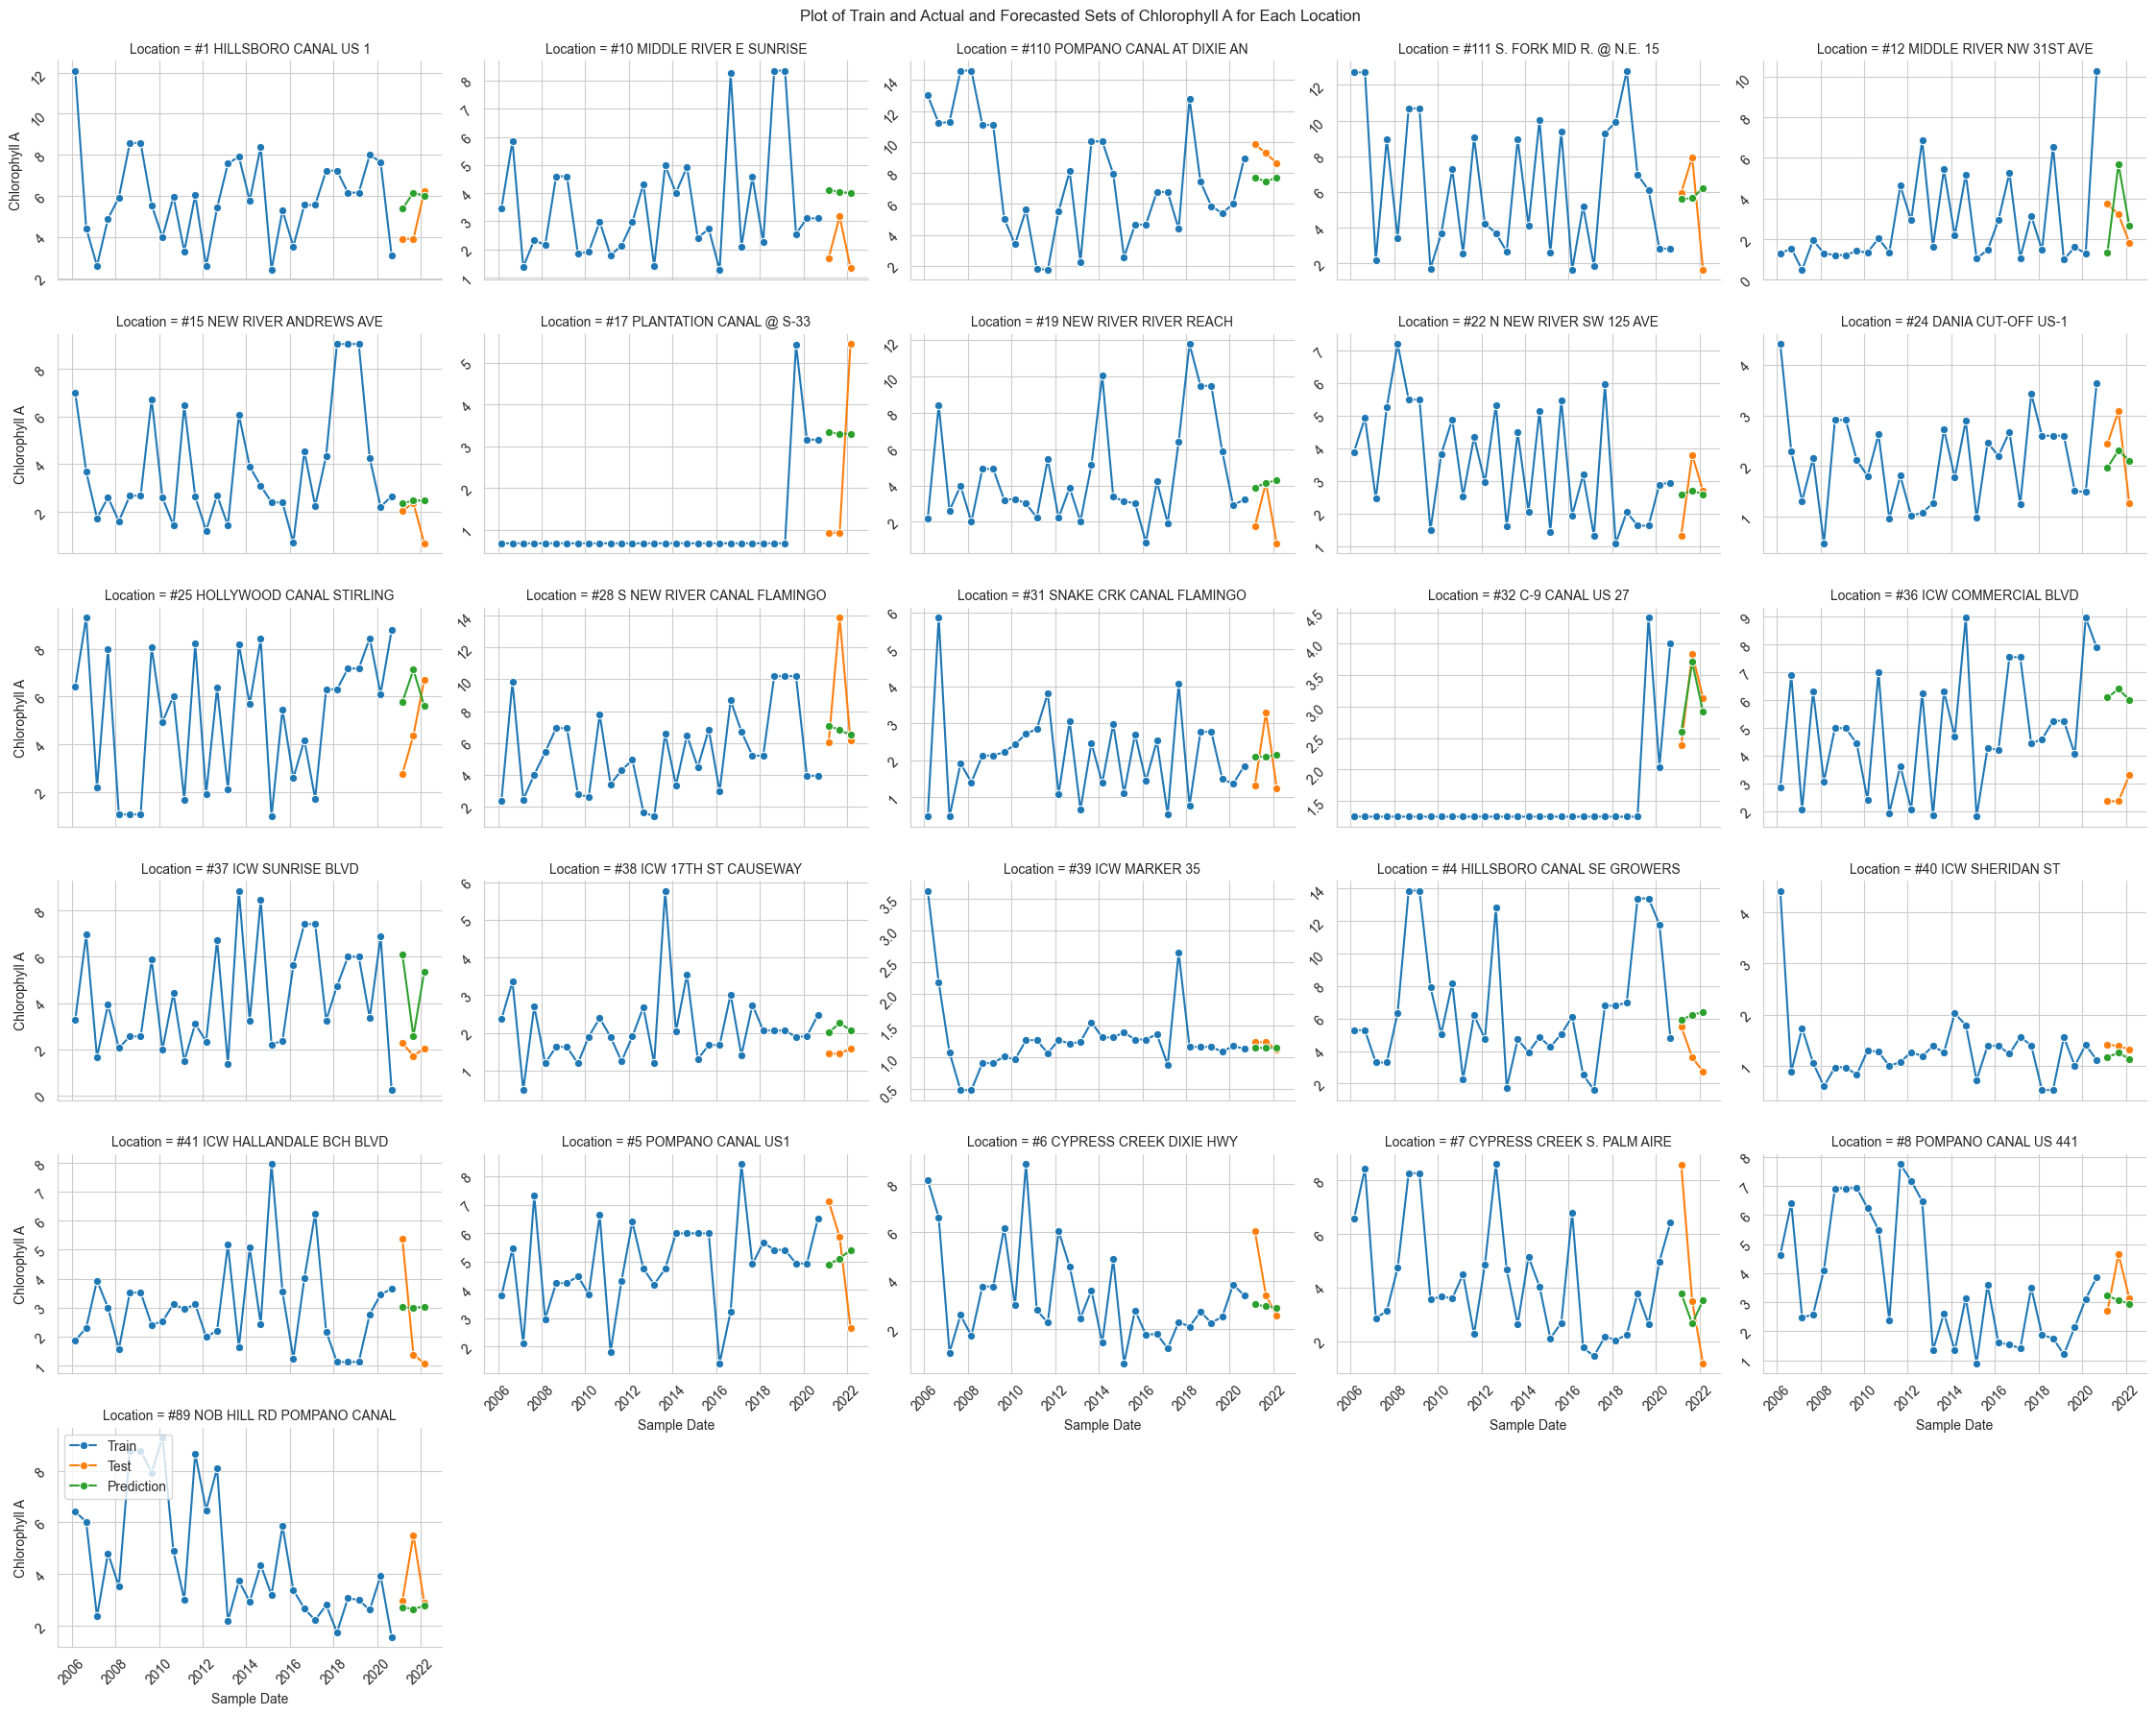

In [8]:
# Convert "Sample Date" to datetime
combined_data["Sample Date"] = pd.to_datetime(combined_data["Sample Date"])

# Create facet plot
plt.figure(figsize=(20, 15))
sns.set_style("whitegrid")
g = sns.FacetGrid(combined_data, col="Location", hue="dataset", col_wrap=5, height=3, aspect=1.5, sharey=False)

# Iterate over each parameter and map them onto the facet grid for both train and test data
line = g.map(sns.lineplot, "Sample Date", param, marker="o")

# Rotate x-axis labels for better readability
for ax in g.axes.ravel():
    ax.tick_params(labelrotation=45)

plt.subplots_adjust(top=0.95)
g.fig.suptitle('Plot of Train and Actual and Forecasted Sets of Chlorophyll A for Each Location')

# Adjust legend
plt.legend(loc='upper left')

plt.show()

In [9]:
maes, mses, rmses = [], [], []
for location in train_data["Location"].unique():
    test_df = test_data[test_data["Location"]==location]
    pred_df = pred_data[pred_data["Location"]==location]
    mae = mean_absolute_error(test_df[param], pred_df[param])
    mse = mean_squared_error(test_df[param], pred_df[param])
    rmse = np.sqrt(mse)

    maes.append(mae)
    mses.append(mse)
    rmses.append(rmse)
accuracy = pd.DataFrame({"Location": train_data["Location"].unique(),
              "MAE": maes,
              "MSE": mses,
              "RMSE": rmses,
            })

In [10]:
accuracy.sort_values(by="RMSE", ascending=False)

Location       MAE        MSE      RMSE
11  #28 S NEW RIVER CANAL FLAMINGO  2.848723  17.217029  4.149341
14         #36 ICW COMMERCIAL BLVD  3.503145  12.591110  3.548395
23   #7 CYPRESS CREEK S. PALM AIRE  2.671188   9.808833  3.131906
15            #37 ICW SUNRISE BLVD  2.665593   8.805649  2.967431
3    #111 S. FORK MID R. @ N.E. 15  2.410788   8.785402  2.964018
18   #4 HILLSBORO CANAL SE GROWERS  2.228629   6.830180  2.613461
10    #25 HOLLYWOOD CANAL STIRLING  2.281727   5.938893  2.436984
7        #19 NEW RIVER RIVER REACH  1.863521   5.507477  2.346801
6      #17 PLANTATION CANAL @ S-33  2.309488   5.346221  2.312190
1       #10 MIDDLE RIVER E SUNRISE  1.981151   4.555569  2.134378
21            #5 POMPANO CANAL US1  1.903317   4.322525  2.079068
4     #12 MIDDLE RIVER NW 31ST AVE  1.892076   4.138766  2.034396
20     #41 ICW HALLANDALE BCH BLVD  1.977382   4.005044  2.001260
22      #6 CYPRESS CREEK DIXIE HWY  1.276354   3.181480  1.783670
2   #110 POMPANO CANAL AT DIXIE AN  1.628592   2.926684  1.710755
25   #89 NOB HILL RD POMPANO CANAL  1.083184   2.778816  1.666978
0          #1 HILLSBORO CANAL US 1  1.312986   2.439041  1.561743
5        #15 NEW RIVER ANDREWS AVE  0.733179   1.099920  1.048771
12    #31 SNAKE CRK CANAL FLAMINGO  0.962098   0.957779  0.978662
24         #8 POMPANO CANAL US 441  0.768204   0.947352  0.973320
8       #22 N NEW RIVER SW 125 AVE  0.818240   0.937069  0.968023
9           #24 DANIA CUT-OFF US-1  0.694976   0.509737  0.713959
16        #38 ICW 17TH ST CAUSEWAY  0.621445   0.406121  0.637276
19             #40 ICW SHERIDAN ST  0.188516   0.037862  0.194582
13             #32 C-9 CANAL US 27  0.188839   0.037386  0.193355
17               #39 ICW MARKER 35  0.068126   0.005609  0.074890

## Dissolved Oxygen

In [11]:
param = 'Dissolved Oxygen'

In [12]:
predictions = []
for location in train_data["Location"].unique():
    train_df = train_data[train_data["Location"]==location]
    test_df = test_data[test_data["Location"]==location]

    # Fit ARIMA model
    order = (2, 1, 1)  # Example (p, d, q)
    model = ARIMA(train_df[param], order=order)
    result = model.fit()

    # Forecast future values
    forecast = result.get_forecast(steps=3)  # Forecasting next 3 years (6 biannual periods) into the future
    forecast_index = pd.date_range(start=train_df["Sample Date"].iloc[-1], periods=4, freq='6M')[1:]
    forecast_values = forecast.predicted_mean

    predictions.append(pd.DataFrame({"Location": [location]*3, "Sample Date": forecast_index,param: forecast_values}))
pred_data = pd.concat(predictions)

/var/folders/9n/nyfs9h7n2lsfs0vd2lq0589h0000gn/T/ipykernel_40936/2550153663.py:13: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=train_df["Sample Date"].iloc[-1], periods=4, freq='6M')[1:]
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates,

In [13]:
# Concatenate train and test data for plotting
combined_data = pd.concat([train_data.assign(dataset='Train'), test_data.assign(dataset='Test'), pred_data.assign(dataset='Prediction')])

<Figure size 2000x1500 with 0 Axes>

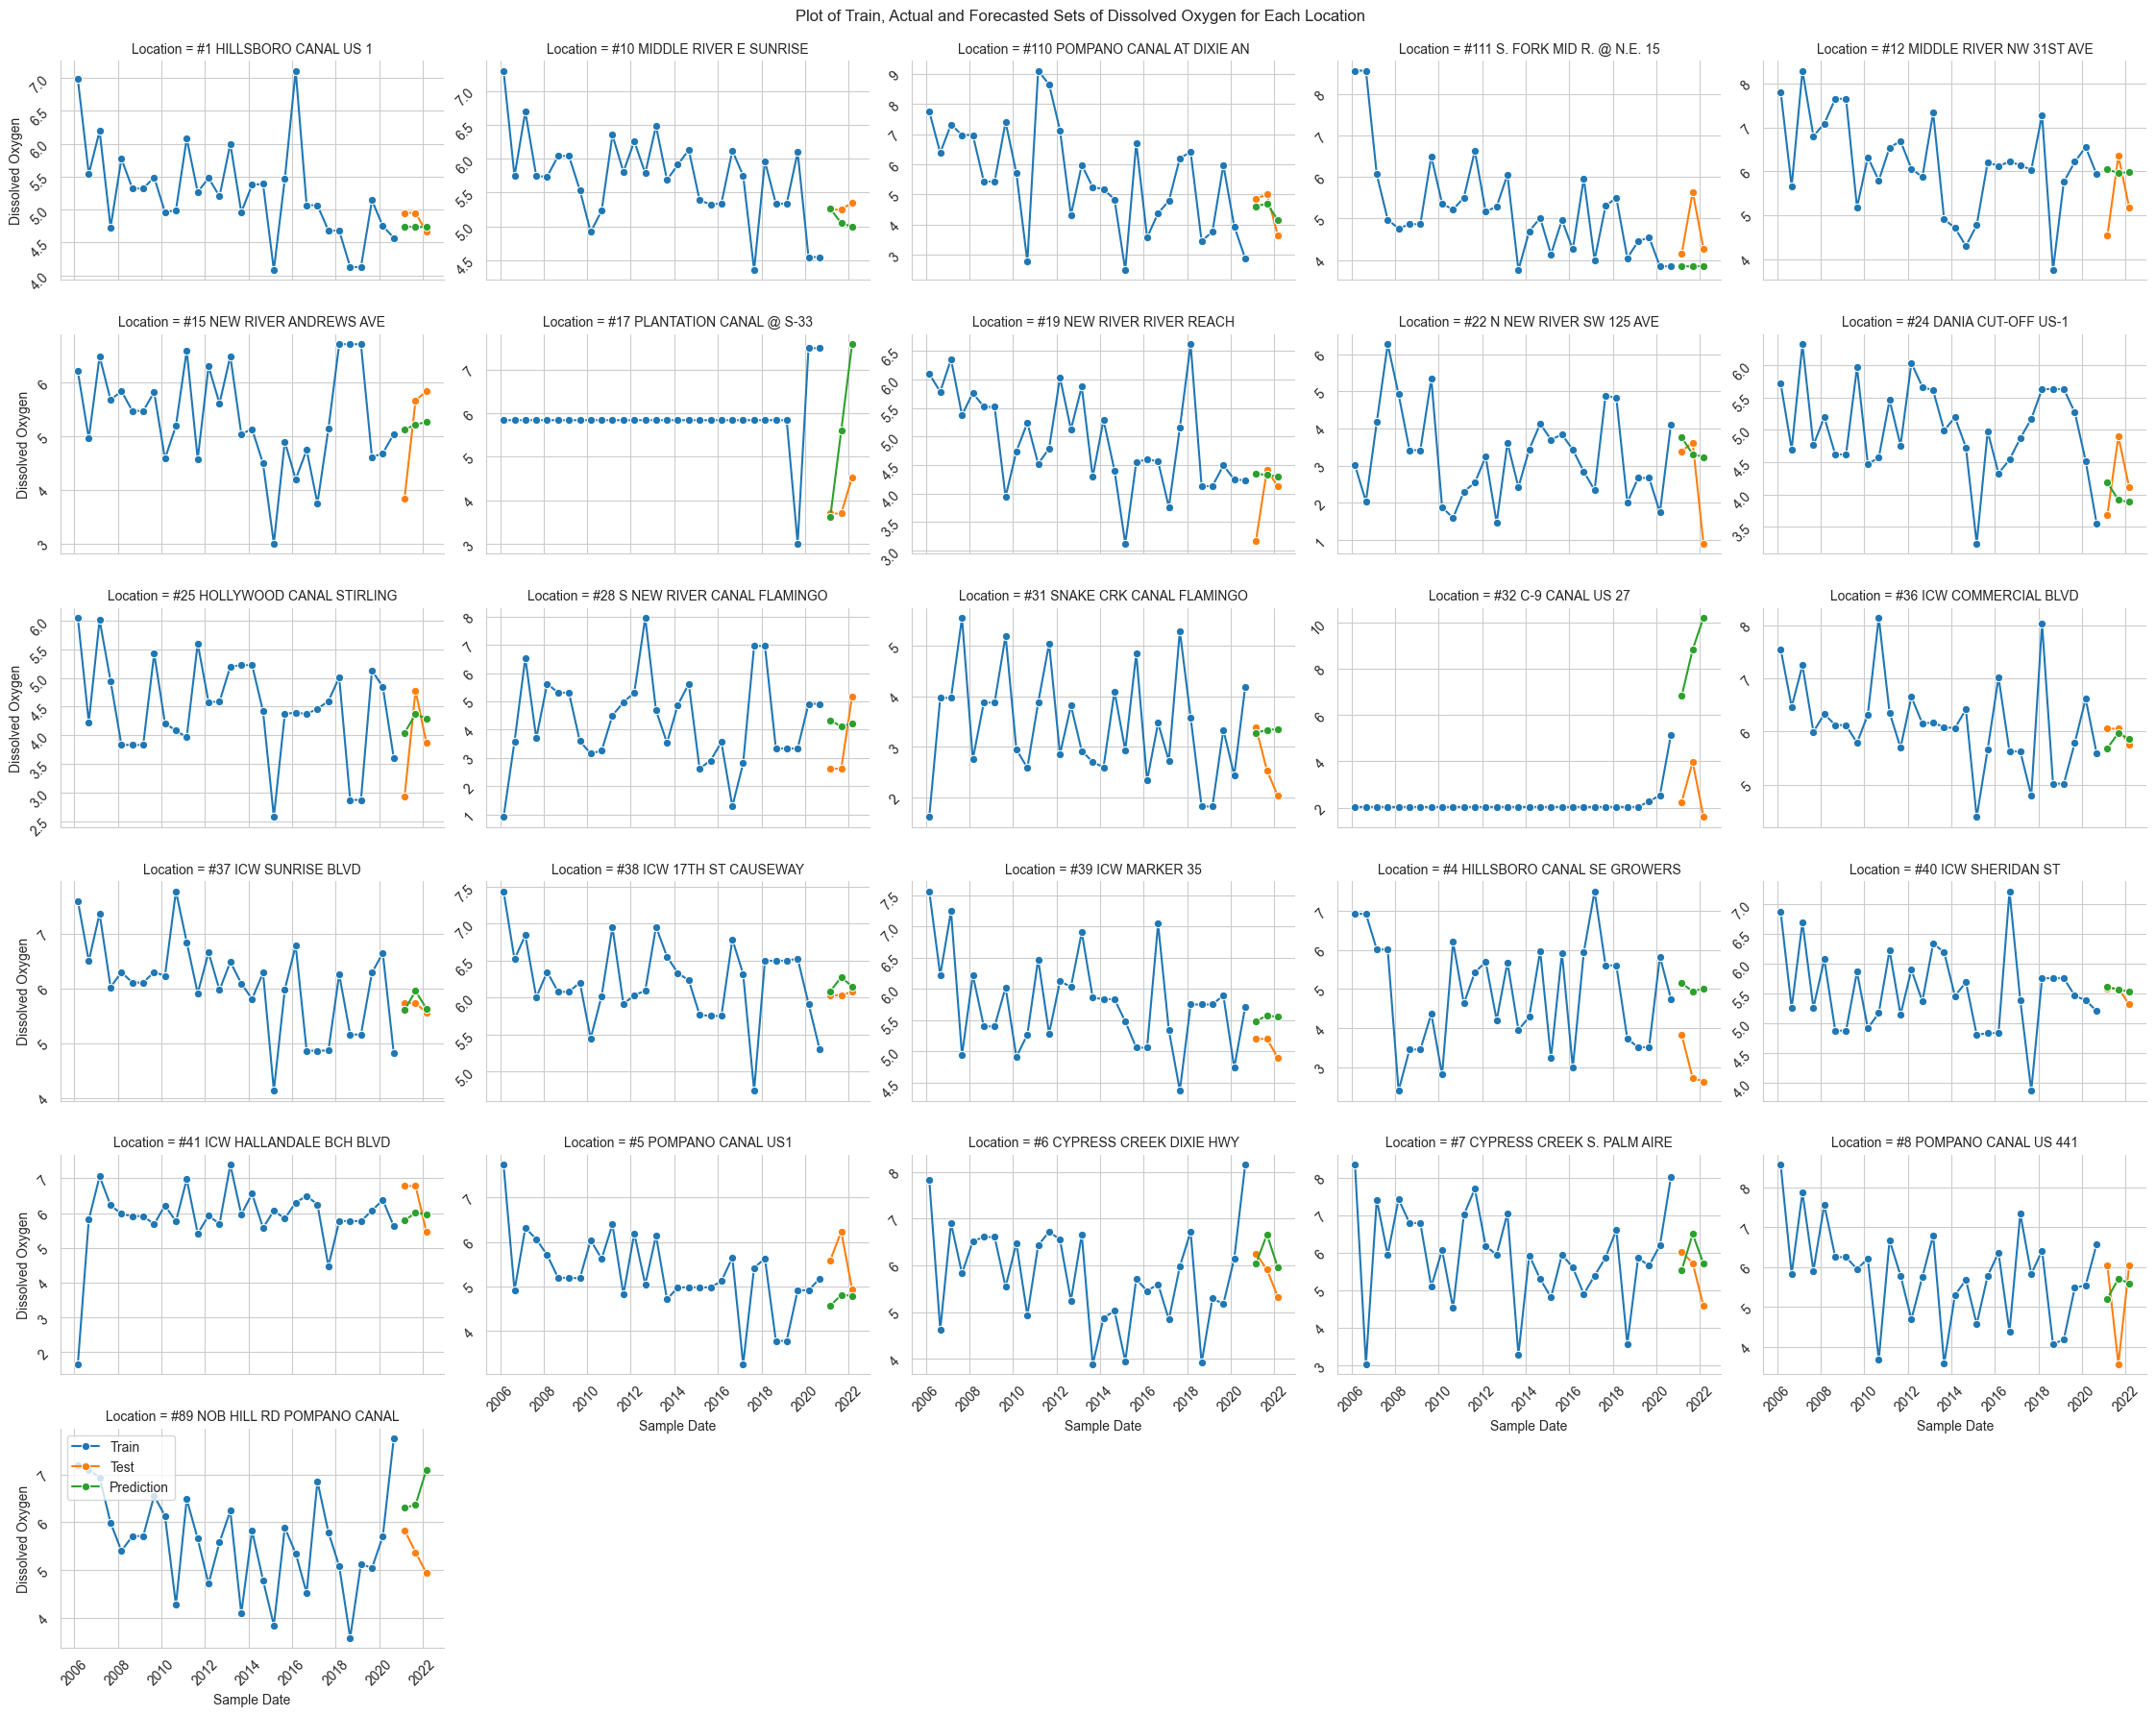

In [14]:
# Convert "Sample Date" to datetime
combined_data["Sample Date"] = pd.to_datetime(combined_data["Sample Date"])

# Determine the maximum and minimum values of param across all locations
param_max = combined_data[param].max()
param_min = combined_data[param].min()

# Create facet plot
plt.figure(figsize=(20, 15))
sns.set_style("whitegrid")
g = sns.FacetGrid(combined_data, col="Location", hue="dataset", col_wrap=5, height=3, aspect=1.5, sharey=False)

# Iterate over each parameter and map them onto the facet grid for both train and test data
line = g.map(sns.lineplot, "Sample Date", param, marker="o")

# Rotate x-axis labels for better readability
for ax in g.axes.ravel():
    ax.tick_params(labelrotation=45)

plt.subplots_adjust(top=0.95)
g.fig.suptitle('Plot of Train, Actual and Forecasted Sets of Dissolved Oxygen for Each Location')

# Adjust legend
plt.legend(loc='upper left')

plt.show()

In [15]:
maes, mses, rmses = [], [], []
for location in train_data["Location"].unique():
    test_df = test_data[test_data["Location"]==location]
    pred_df = pred_data[pred_data["Location"]==location]
    mae = mean_absolute_error(test_df[param], pred_df[param])
    mse = mean_squared_error(test_df[param], pred_df[param])
    rmse = np.sqrt(mse)

    maes.append(mae)
    mses.append(mse)
    rmses.append(rmse)
accuracy = pd.DataFrame({"Location": train_data["Location"].unique(),
              "MAE": maes,
              "MSE": mses,
              "RMSE": rmses,
            })

In [16]:
accuracy.sort_values(by="RMSE", ascending=False)

Location       MAE        MSE      RMSE
13             #32 C-9 CANAL US 27  6.008256  39.477652  6.283124
6      #17 PLANTATION CANAL @ S-33  1.680396   4.318018  2.077984
18   #4 HILLSBORO CANAL SE GROWERS  1.977865   4.125594  2.031156
11  #28 S NEW RIVER CANAL FLAMINGO  1.384462   2.019141  1.420965
25   #89 NOB HILL RD POMPANO CANAL  1.205835   1.949425  1.396218
8       #22 N NEW RIVER SW 125 AVE  1.002656   1.888708  1.374303
24         #8 POMPANO CANAL US 441  1.142177   1.832705  1.353775
3    #111 S. FORK MID R. @ N.E. 15  0.838907   1.165177  1.079434
21            #5 POMPANO CANAL US1  0.867751   1.038586  1.019110
4     #12 MIDDLE RIVER NW 31ST AVE  0.895353   1.016417  1.008175
12    #31 SNAKE CRK CANAL FLAMINGO  0.741890   0.795624  0.891977
5        #15 NEW RIVER ANDREWS AVE  0.766367   0.721183  0.849225
23   #7 CYPRESS CREEK S. PALM AIRE  0.796887   0.704816  0.839533
20     #41 ICW HALLANDALE BCH BLVD  0.750678   0.606985  0.779092
10    #25 HOLLYWOOD CANAL STIRLING  0.651836   0.532865  0.729976
7        #19 NEW RIVER RIVER REACH  0.483304   0.473848  0.688366
9           #24 DANIA CUT-OFF US-1  0.567299   0.419491  0.647681
22      #6 CYPRESS CREEK DIXIE HWY  0.529409   0.332605  0.576719
17               #39 ICW MARKER 35  0.435689   0.214404  0.463038
2   #110 POMPANO CANAL AT DIXIE AN  0.351807   0.135277  0.367800
1       #10 MIDDLE RIVER E SUNRISE  0.188895   0.055344  0.235252
14         #36 ICW COMMERCIAL BLVD  0.181256   0.049604  0.222720
0          #1 HILLSBORO CANAL US 1  0.165408   0.031718  0.178095
15            #37 ICW SUNRISE BLVD  0.139842   0.023458  0.153159
16        #38 ICW 17TH ST CAUSEWAY  0.124205   0.022685  0.150615
19             #40 ICW SHERIDAN ST  0.086993   0.015893  0.126068

## Salinity

In [17]:
param = 'Salinity'

In [18]:
predictions = []
for location in train_data["Location"].unique():
    train_df = train_data[train_data["Location"]==location]
    test_df = test_data[test_data["Location"]==location]

    # Fit ARIMA model
    order = (2, 1, 1)  # Example (p, d, q)
    model = ARIMA(train_df[param], order=order)
    result = model.fit()

    # Forecast future values
    forecast = result.get_forecast(steps=3)  # Forecasting next 3 years (6 biannual periods) into the future
    forecast_index = pd.date_range(start=train_df["Sample Date"].iloc[-1], periods=4, freq='6M')[1:]
    forecast_values = forecast.predicted_mean

    predictions.append(pd.DataFrame({"Location": [location]*3, "Sample Date": forecast_index,param: forecast_values}))
pred_data = pd.concat(predictions)

/var/folders/9n/nyfs9h7n2lsfs0vd2lq0589h0000gn/T/ipykernel_40936/2550153663.py:13: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=train_df["Sample Date"].iloc[-1], periods=4, freq='6M')[1:]
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates,

In [19]:
# Concatenate train and test data for plotting
combined_data = pd.concat([train_data.assign(dataset='Train'), test_data.assign(dataset='Test'), pred_data.assign(dataset='Prediction')])

<Figure size 2000x1500 with 0 Axes>

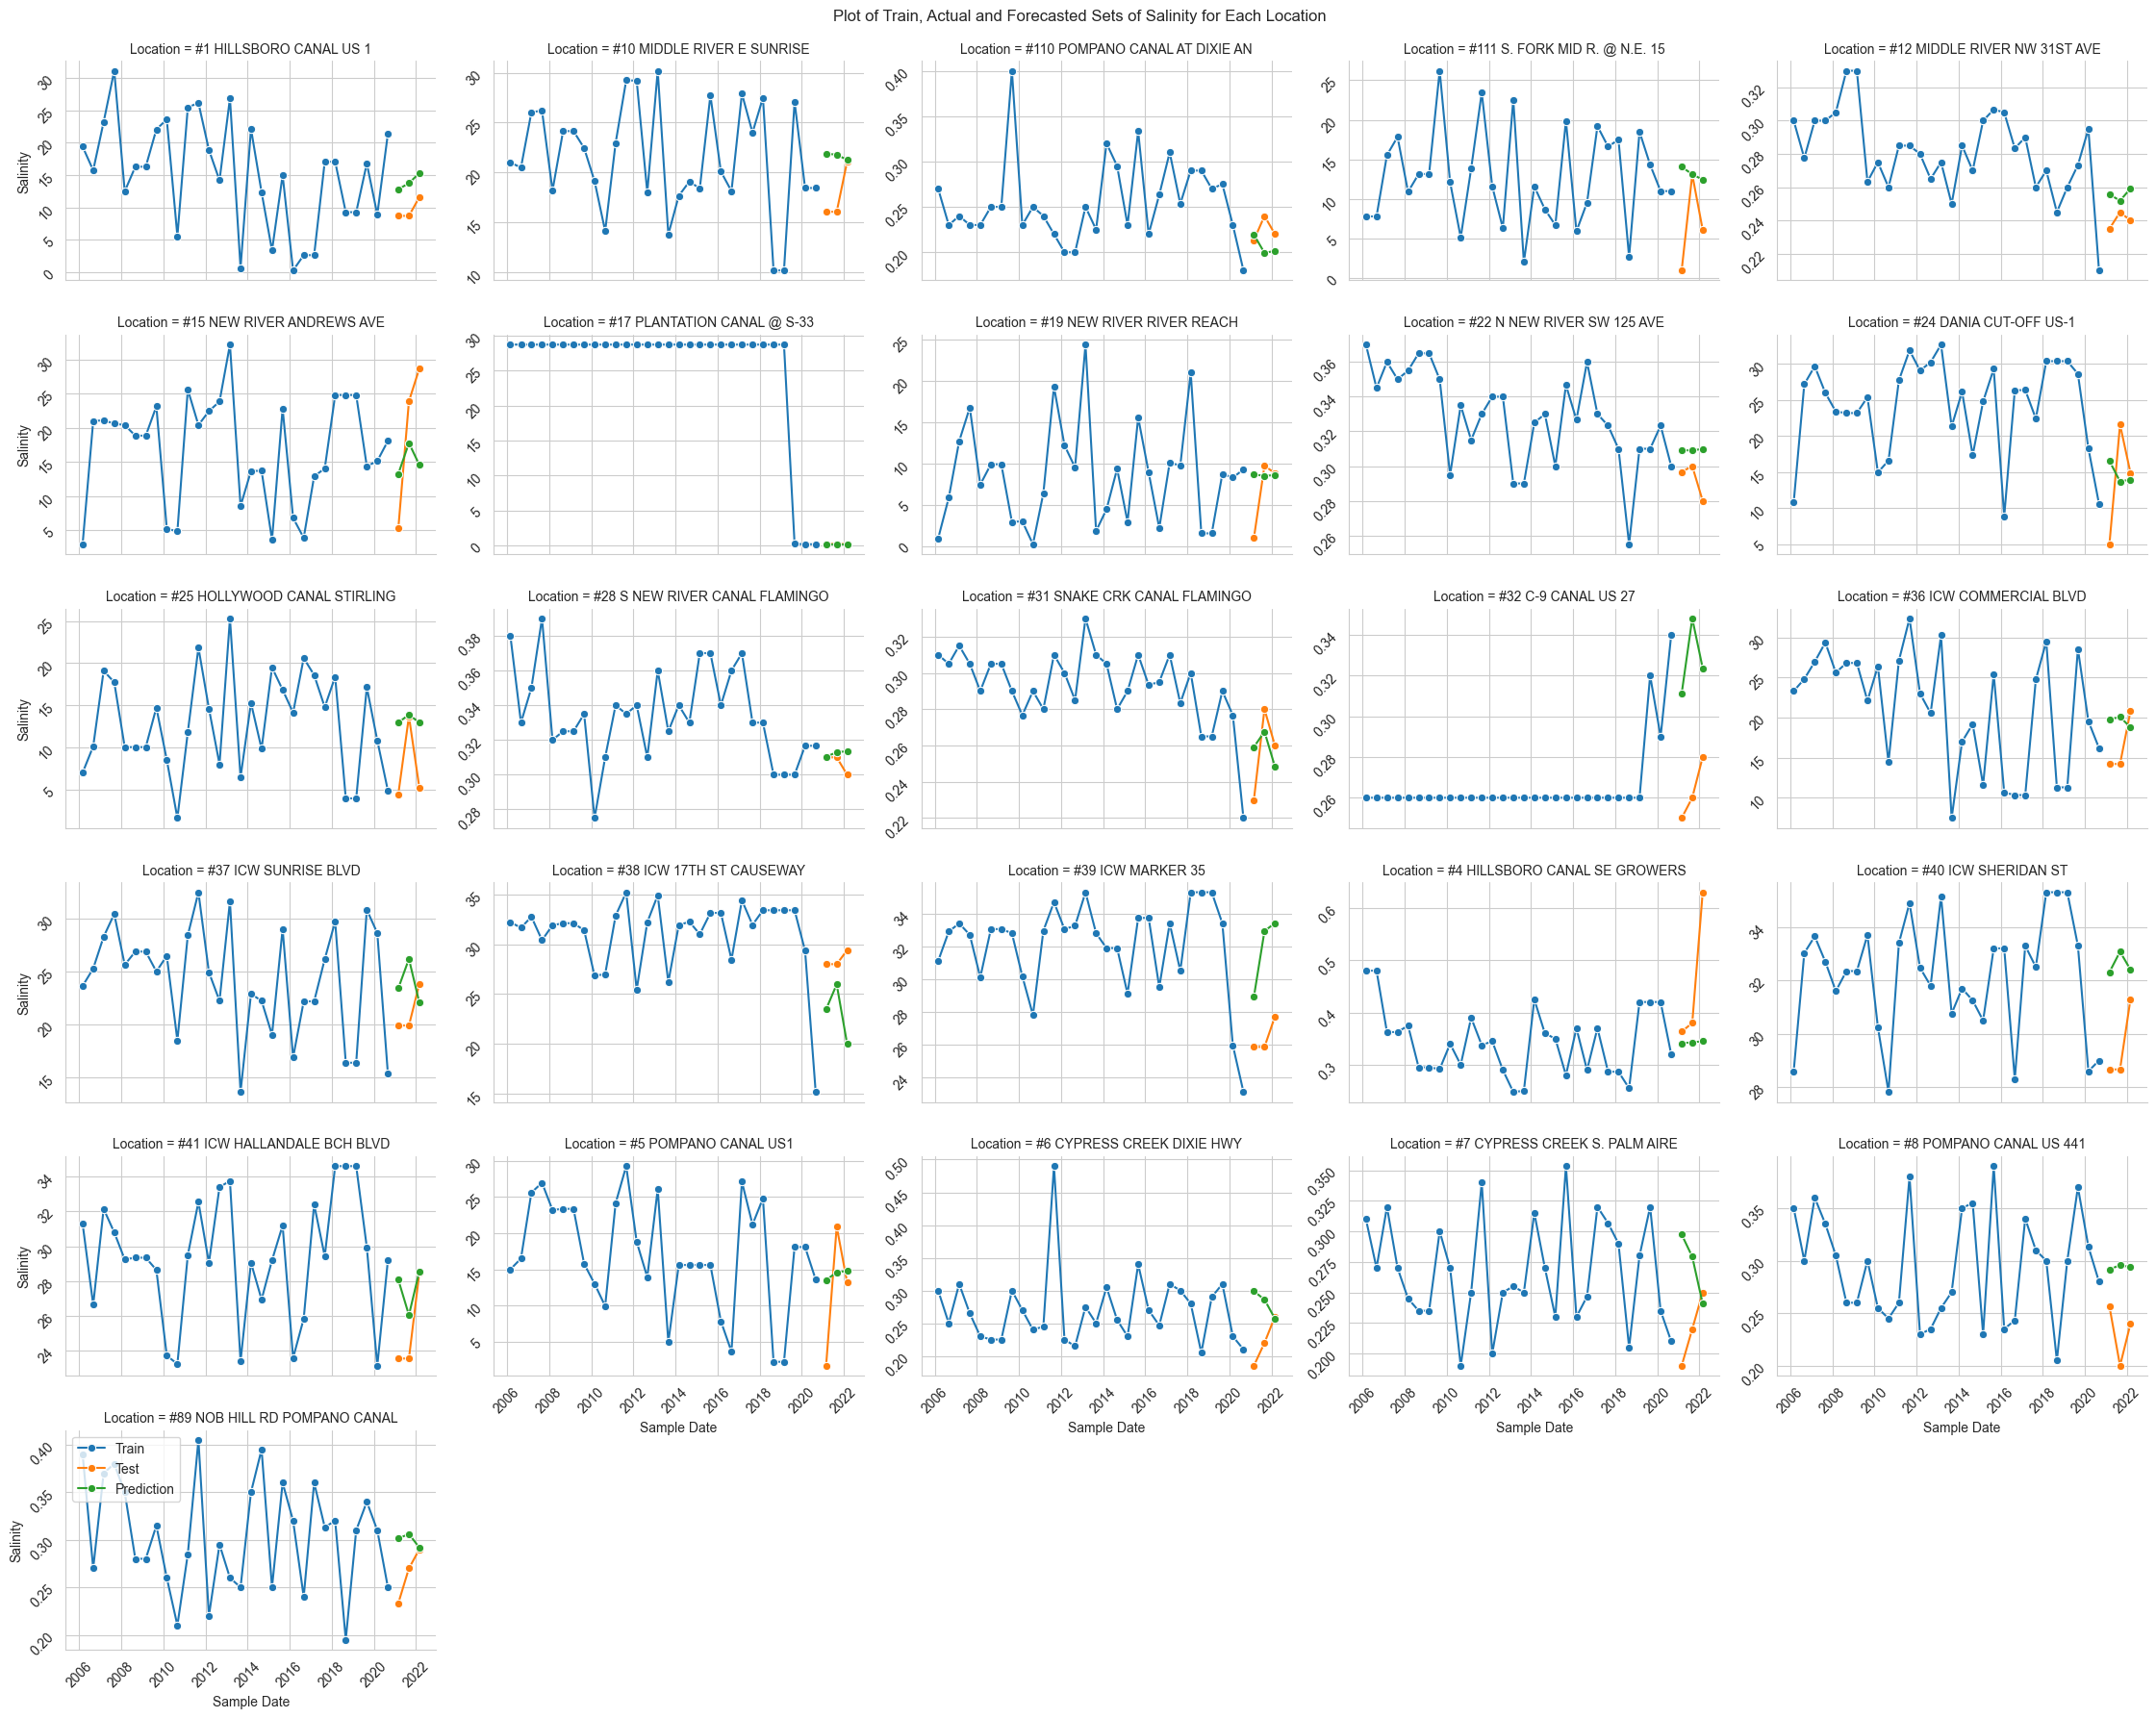

In [20]:
# Convert "Sample Date" to datetime
combined_data["Sample Date"] = pd.to_datetime(combined_data["Sample Date"])

# Determine the maximum and minimum values of param across all locations
param_max = combined_data[param].max()
param_min = combined_data[param].min()

# Create facet plot
plt.figure(figsize=(20, 15))
sns.set_style("whitegrid")
g = sns.FacetGrid(combined_data, col="Location", hue="dataset", col_wrap=5, height=3, aspect=1.5, sharey=False)

# Iterate over each parameter and map them onto the facet grid for both train and test data
line = g.map(sns.lineplot, "Sample Date", param, marker="o")

# Rotate x-axis labels for better readability
for ax in g.axes.ravel():
    ax.tick_params(labelrotation=45)

plt.subplots_adjust(top=0.95)
g.fig.suptitle('Plot of Train, Actual and Forecasted Sets of Salinity for Each Location')

# Adjust legend
plt.legend(loc='upper left')

plt.show()

In [21]:
maes, mses, rmses = [], [], []
for location in train_data["Location"].unique():
    test_df = test_data[test_data["Location"]==location]
    pred_df = pred_data[pred_data["Location"]==location]
    mae = mean_absolute_error(test_df[param], pred_df[param])
    mse = mean_squared_error(test_df[param], pred_df[param])
    rmse = np.sqrt(mse)

    maes.append(mae)
    mses.append(mse)
    rmses.append(rmse)
accuracy = pd.DataFrame({"Location": train_data["Location"].unique(),
              "MAE": maes,
              "MSE": mses,
              "RMSE": rmses,
            })

In [22]:
accuracy.sort_values(by="RMSE", ascending=False)

Location       MAE         MSE       RMSE
5        #15 NEW RIVER ANDREWS AVE  9.415850  100.372407  10.018603
3    #111 S. FORK MID R. @ N.E. 15  6.475069   70.278909   8.383252
9           #24 DANIA CUT-OFF US-1  6.800747   65.695382   8.105269
21            #5 POMPANO CANAL US1  6.576738   60.811128   7.798149
10    #25 HOLLYWOOD CANAL STIRLING  5.463213   43.733230   6.613110
16        #38 ICW 17TH ST CAUSEWAY  5.310815   37.570987   6.129518
17               #39 ICW MARKER 35  5.284794   30.720366   5.542596
14         #36 ICW COMMERCIAL BLVD  4.477980   23.098964   4.806138
1       #10 MIDDLE RIVER E SUNRISE  3.895292   22.165481   4.708023
7        #19 NEW RIVER RIVER REACH  3.057252   20.376161   4.513996
0          #1 HILLSBORO CANAL US 1  4.287668   18.689199   4.323101
15            #37 ICW SUNRISE BLVD  3.862927   18.378623   4.287030
19             #40 ICW SHERIDAN ST  3.052874   11.316206   3.363957
20     #41 ICW HALLANDALE BCH BLVD  2.360069    8.862839   2.977052
18   #4 HILLSBORO CANAL SE GROWERS  0.114806    0.027713   0.166473
22      #6 CYPRESS CREEK DIXIE HWY  0.061011    0.005795   0.076128
23   #7 CYPRESS CREEK S. PALM AIRE  0.058656    0.005046   0.071036
13             #32 C-9 CANAL US 27  0.064279    0.004465   0.066821
24         #8 POMPANO CANAL US 441  0.061566    0.004436   0.066606
25   #89 NOB HILL RD POMPANO CANAL  0.035338    0.001982   0.044516
6      #17 PLANTATION CANAL @ S-33  0.033333    0.001200   0.034641
2   #110 POMPANO CANAL AT DIXIE AN  0.021762    0.000679   0.026053
12    #31 SNAKE CRK CANAL FLAMINGO  0.017694    0.000379   0.019457
8       #22 N NEW RIVER SW 125 AVE  0.017121    0.000376   0.019393
4     #12 MIDDLE RIVER NW 31ST AVE  0.015612    0.000282   0.016797
11  #28 S NEW RIVER CANAL FLAMINGO  0.005611    0.000064   0.008003

## Specific Conductance

In [23]:
param = 'Specific Conductance'

In [24]:
predictions = []
for location in train_data["Location"].unique():
    train_df = train_data[train_data["Location"]==location]
    test_df = test_data[test_data["Location"]==location]

    # Fit ARIMA model
    order = (2, 1, 1)  # Example (p, d, q)
    model = ARIMA(train_df[param], order=order)
    result = model.fit()

    # Forecast future values
    forecast = result.get_forecast(steps=3)  # Forecasting next 3 years (6 biannual periods) into the future
    forecast_index = pd.date_range(start=train_df["Sample Date"].iloc[-1], periods=4, freq='6M')[1:]
    forecast_values = forecast.predicted_mean

    predictions.append(pd.DataFrame({"Location": [location]*3, "Sample Date": forecast_index,param: forecast_values}))
pred_data = pd.concat(predictions)

/var/folders/9n/nyfs9h7n2lsfs0vd2lq0589h0000gn/T/ipykernel_40936/2550153663.py:13: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=train_df["Sample Date"].iloc[-1], periods=4, freq='6M')[1:]
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates,

In [25]:
# Concatenate train and test data for plotting
combined_data = pd.concat([train_data.assign(dataset='Train'), test_data.assign(dataset='Test'), pred_data.assign(dataset='Prediction')])

<Figure size 2000x1500 with 0 Axes>

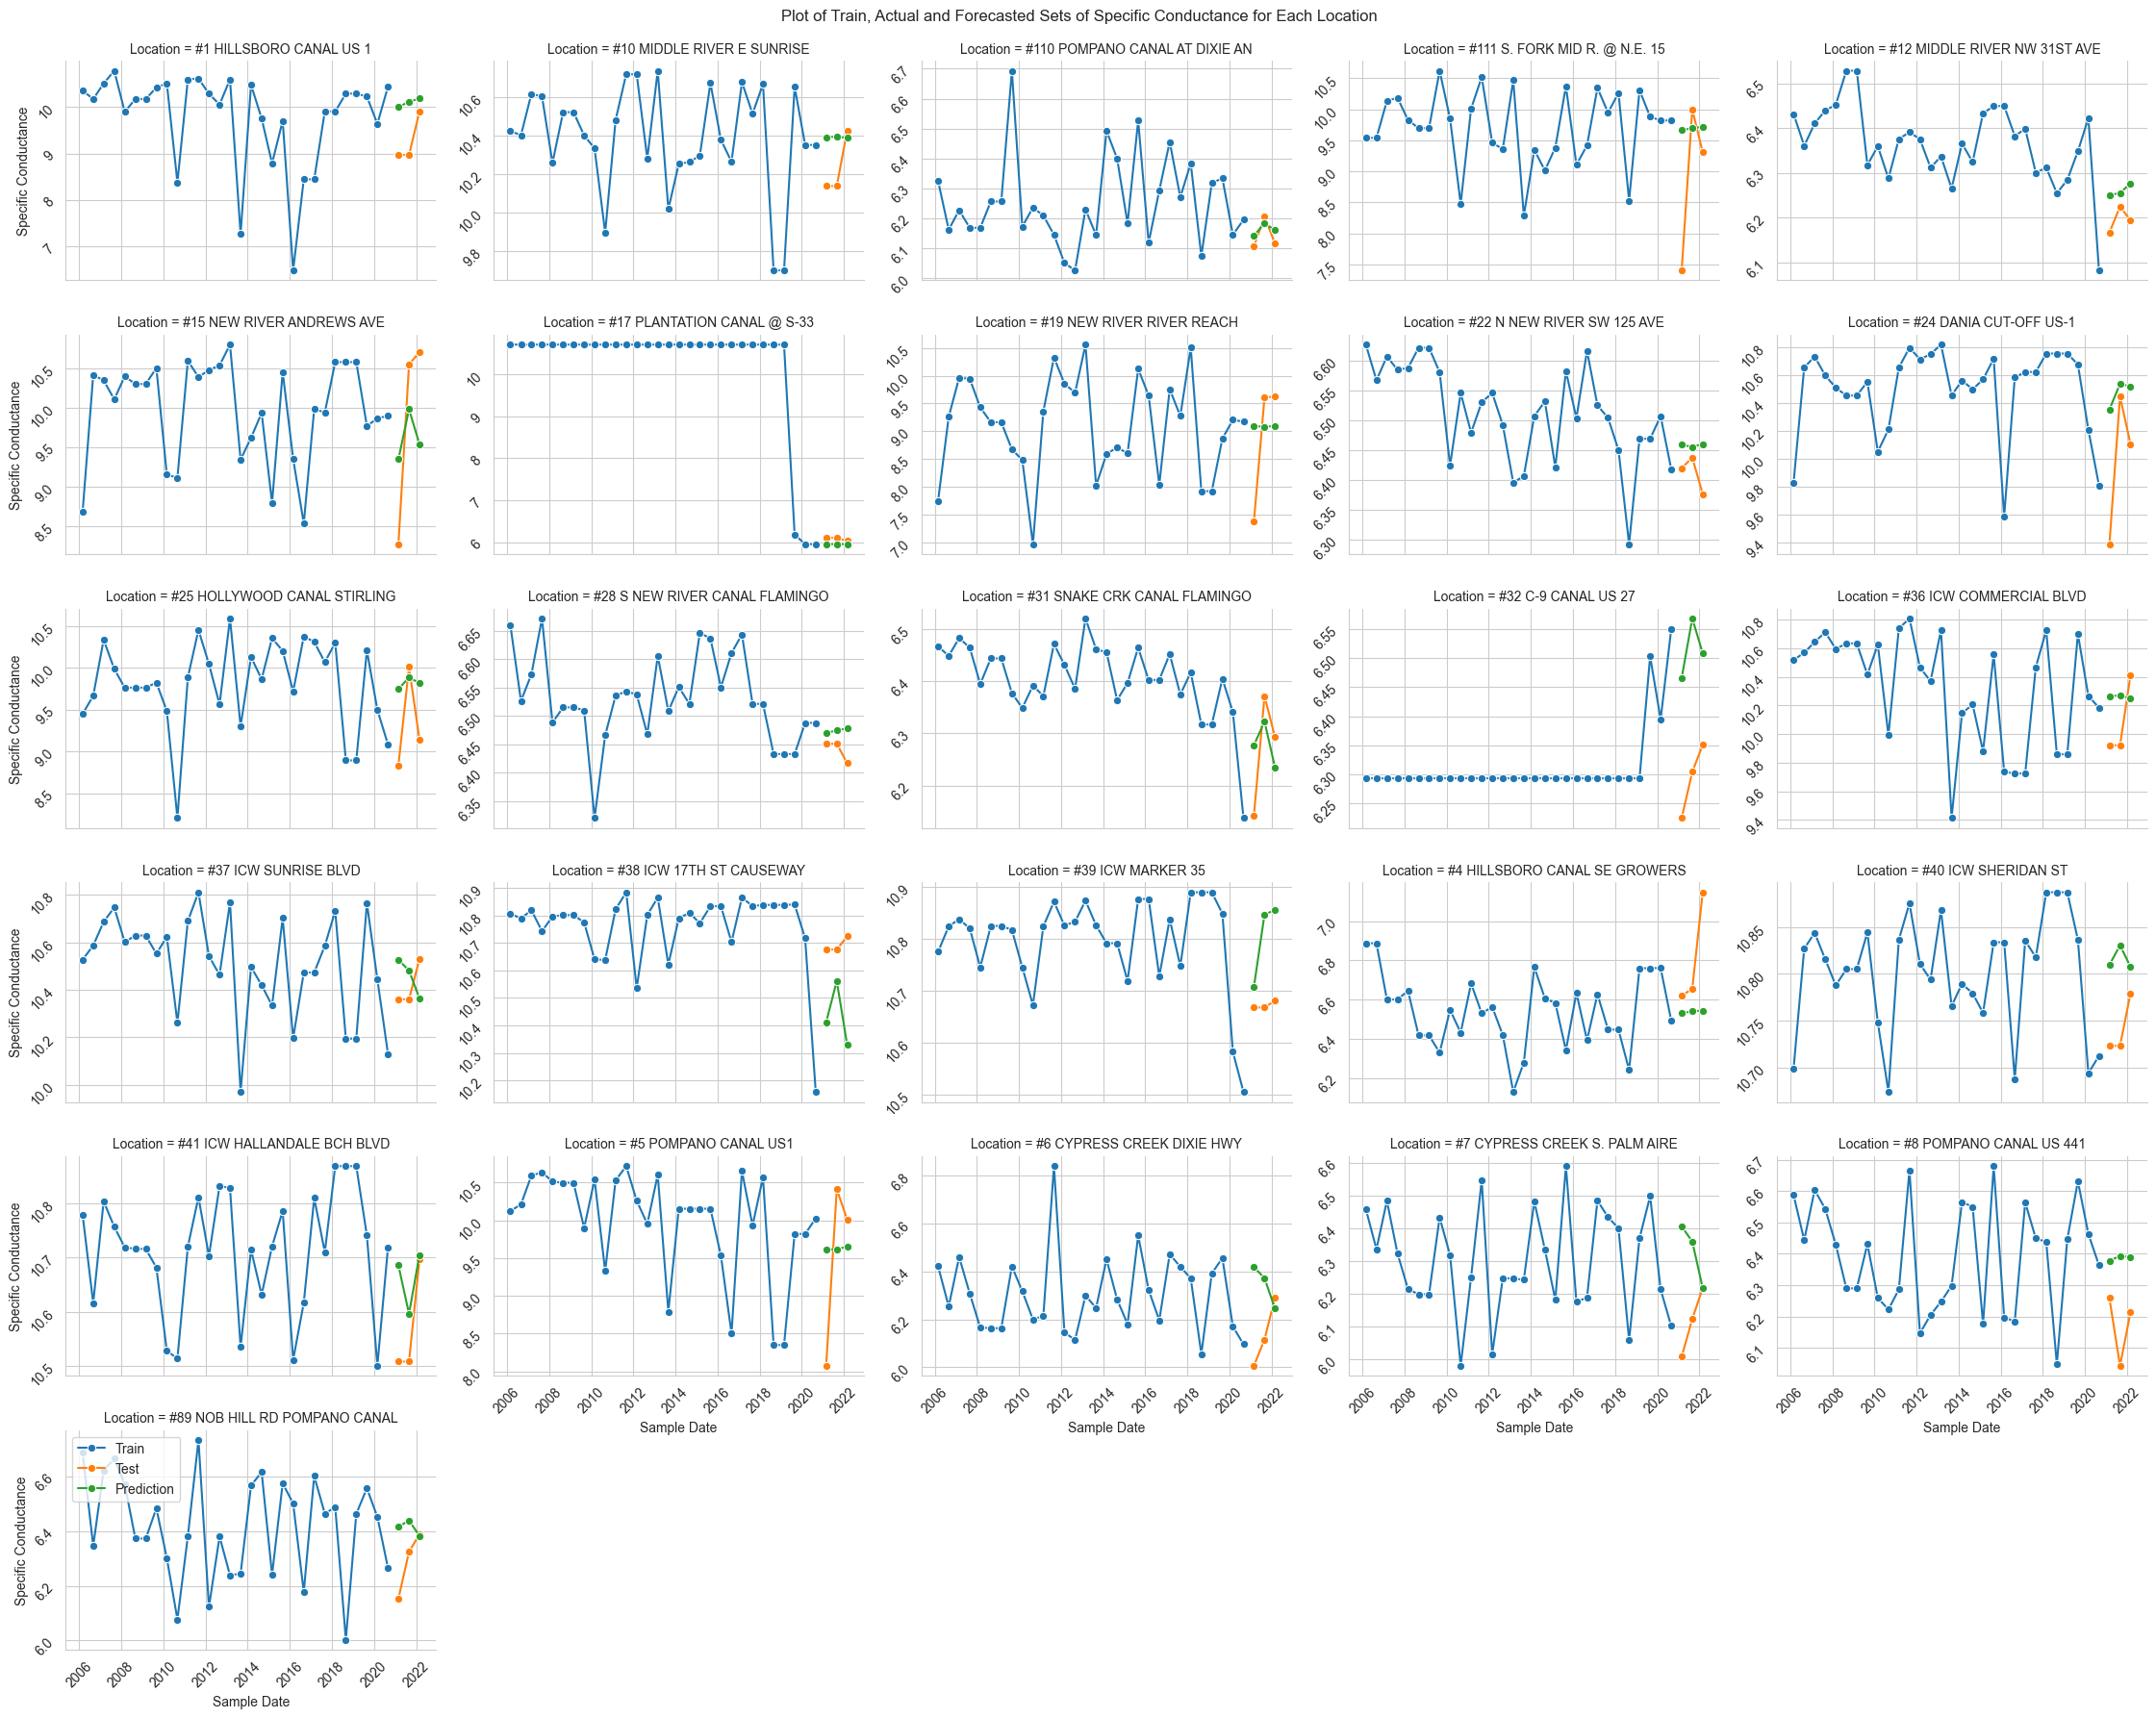

In [26]:
# Convert "Sample Date" to datetime
combined_data["Sample Date"] = pd.to_datetime(combined_data["Sample Date"])

# Determine the maximum and minimum values of param across all locations
param_max = combined_data[param].max()
param_min = combined_data[param].min()

# Create facet plot
plt.figure(figsize=(20, 15))
sns.set_style("whitegrid")
g = sns.FacetGrid(combined_data, col="Location", hue="dataset", col_wrap=5, height=3, aspect=1.5, sharey=False)

# Iterate over each parameter and map them onto the facet grid for both train and test data
line = g.map(sns.lineplot, "Sample Date", param, marker="o")

# Rotate x-axis labels for better readability
for ax in g.axes.ravel():
    ax.tick_params(labelrotation=45)

plt.subplots_adjust(top=0.95)
g.fig.suptitle('Plot of Train, Actual and Forecasted Sets of Specific Conductance for Each Location')

# Adjust legend
plt.legend(loc='upper left')

plt.show()

In [27]:
maes, mses, rmses = [], [], []
for location in train_data["Location"].unique():
    test_df = test_data[test_data["Location"]==location]
    pred_df = pred_data[pred_data["Location"]==location]
    mae = mean_absolute_error(test_df[param], pred_df[param])
    mse = mean_squared_error(test_df[param], pred_df[param])
    rmse = np.sqrt(mse)

    maes.append(mae)
    mses.append(mse)
    rmses.append(rmse)
accuracy = pd.DataFrame({"Location": train_data["Location"].unique(),
              "MAE": maes,
              "MSE": mses,
              "RMSE": rmses,
            })

In [28]:
accuracy.sort_values(by="RMSE", ascending=False)

Location       MAE       MSE      RMSE
3    #111 S. FORK MID R. @ N.E. 15  0.991684  1.789007  1.337538
7        #19 NEW RIVER RIVER REACH  0.925818  1.171697  1.082449
21            #5 POMPANO CANAL US1  0.898263  1.046440  1.022956
5        #15 NEW RIVER ANDREWS AVE  0.934694  0.943237  0.971204
0          #1 HILLSBORO CANAL US 1  0.817764  0.811187  0.900659
10    #25 HOLLYWOOD CANAL STIRLING  0.569893  0.433189  0.658171
9           #24 DANIA CUT-OFF US-1  0.489117  0.369768  0.608086
18   #4 HILLSBORO CANAL SE GROWERS  0.269092  0.128416  0.358352
14         #36 ICW COMMERCIAL BLVD  0.284487  0.088467  0.297434
16        #38 ICW 17TH ST CAUSEWAY  0.257823  0.079666  0.282252
22      #6 CYPRESS CREEK DIXIE HWY  0.238779  0.079567  0.282077
23   #7 CYPRESS CREEK S. PALM AIRE  0.211213  0.071105  0.266655
24         #8 POMPANO CANAL US 441  0.215527  0.056033  0.236714
13             #32 C-9 CANAL US 27  0.220614  0.050743  0.225262
1       #10 MIDDLE RIVER E SUNRISE  0.182787  0.043775  0.209224
25   #89 NOB HILL RD POMPANO CANAL  0.127697  0.027246  0.165064
15            #37 ICW SUNRISE BLVD  0.150786  0.023182  0.152256
17               #39 ICW MARKER 35  0.131200  0.021383  0.146228
6      #17 PLANTATION CANAL @ S-33  0.127413  0.017517  0.132353
20     #41 ICW HALLANDALE BCH BLVD  0.091293  0.013122  0.114550
12    #31 SNAKE CRK CANAL FLAMINGO  0.080577  0.007985  0.089356
19             #40 ICW SHERIDAN ST  0.074359  0.006637  0.081467
4     #12 MIDDLE RIVER NW 31ST AVE  0.065312  0.004870  0.069784
8       #22 N NEW RIVER SW 125 AVE  0.046864  0.002951  0.054324
11  #28 S NEW RIVER CANAL FLAMINGO  0.034354  0.001541  0.039260
2   #110 POMPANO CANAL AT DIXIE AN  0.033820  0.001225  0.034996

## Total Nitrogen

In [29]:
param = 'Total Nitrogen'

In [30]:
predictions = []
for location in train_data["Location"].unique():
    train_df = train_data[train_data["Location"]==location]
    test_df = test_data[test_data["Location"]==location]

    # Fit ARIMA model
    order = (2, 1, 1)  # Example (p, d, q)
    model = ARIMA(train_df[param], order=order)
    result = model.fit()

    # Forecast future values
    forecast = result.get_forecast(steps=3)  # Forecasting next 3 years (6 biannual periods) into the future
    forecast_index = pd.date_range(start=train_df["Sample Date"].iloc[-1], periods=4, freq='6M')[1:]
    forecast_values = forecast.predicted_mean

    predictions.append(pd.DataFrame({"Location": [location]*3, "Sample Date": forecast_index,param: forecast_values}))
pred_data = pd.concat(predictions)

/var/folders/9n/nyfs9h7n2lsfs0vd2lq0589h0000gn/T/ipykernel_40936/2550153663.py:13: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=train_df["Sample Date"].iloc[-1], periods=4, freq='6M')[1:]
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates,

In [31]:
# Concatenate train and test data for plotting
combined_data = pd.concat([train_data.assign(dataset='Train'), test_data.assign(dataset='Test'), pred_data.assign(dataset='Prediction')])

<Figure size 2000x1500 with 0 Axes>

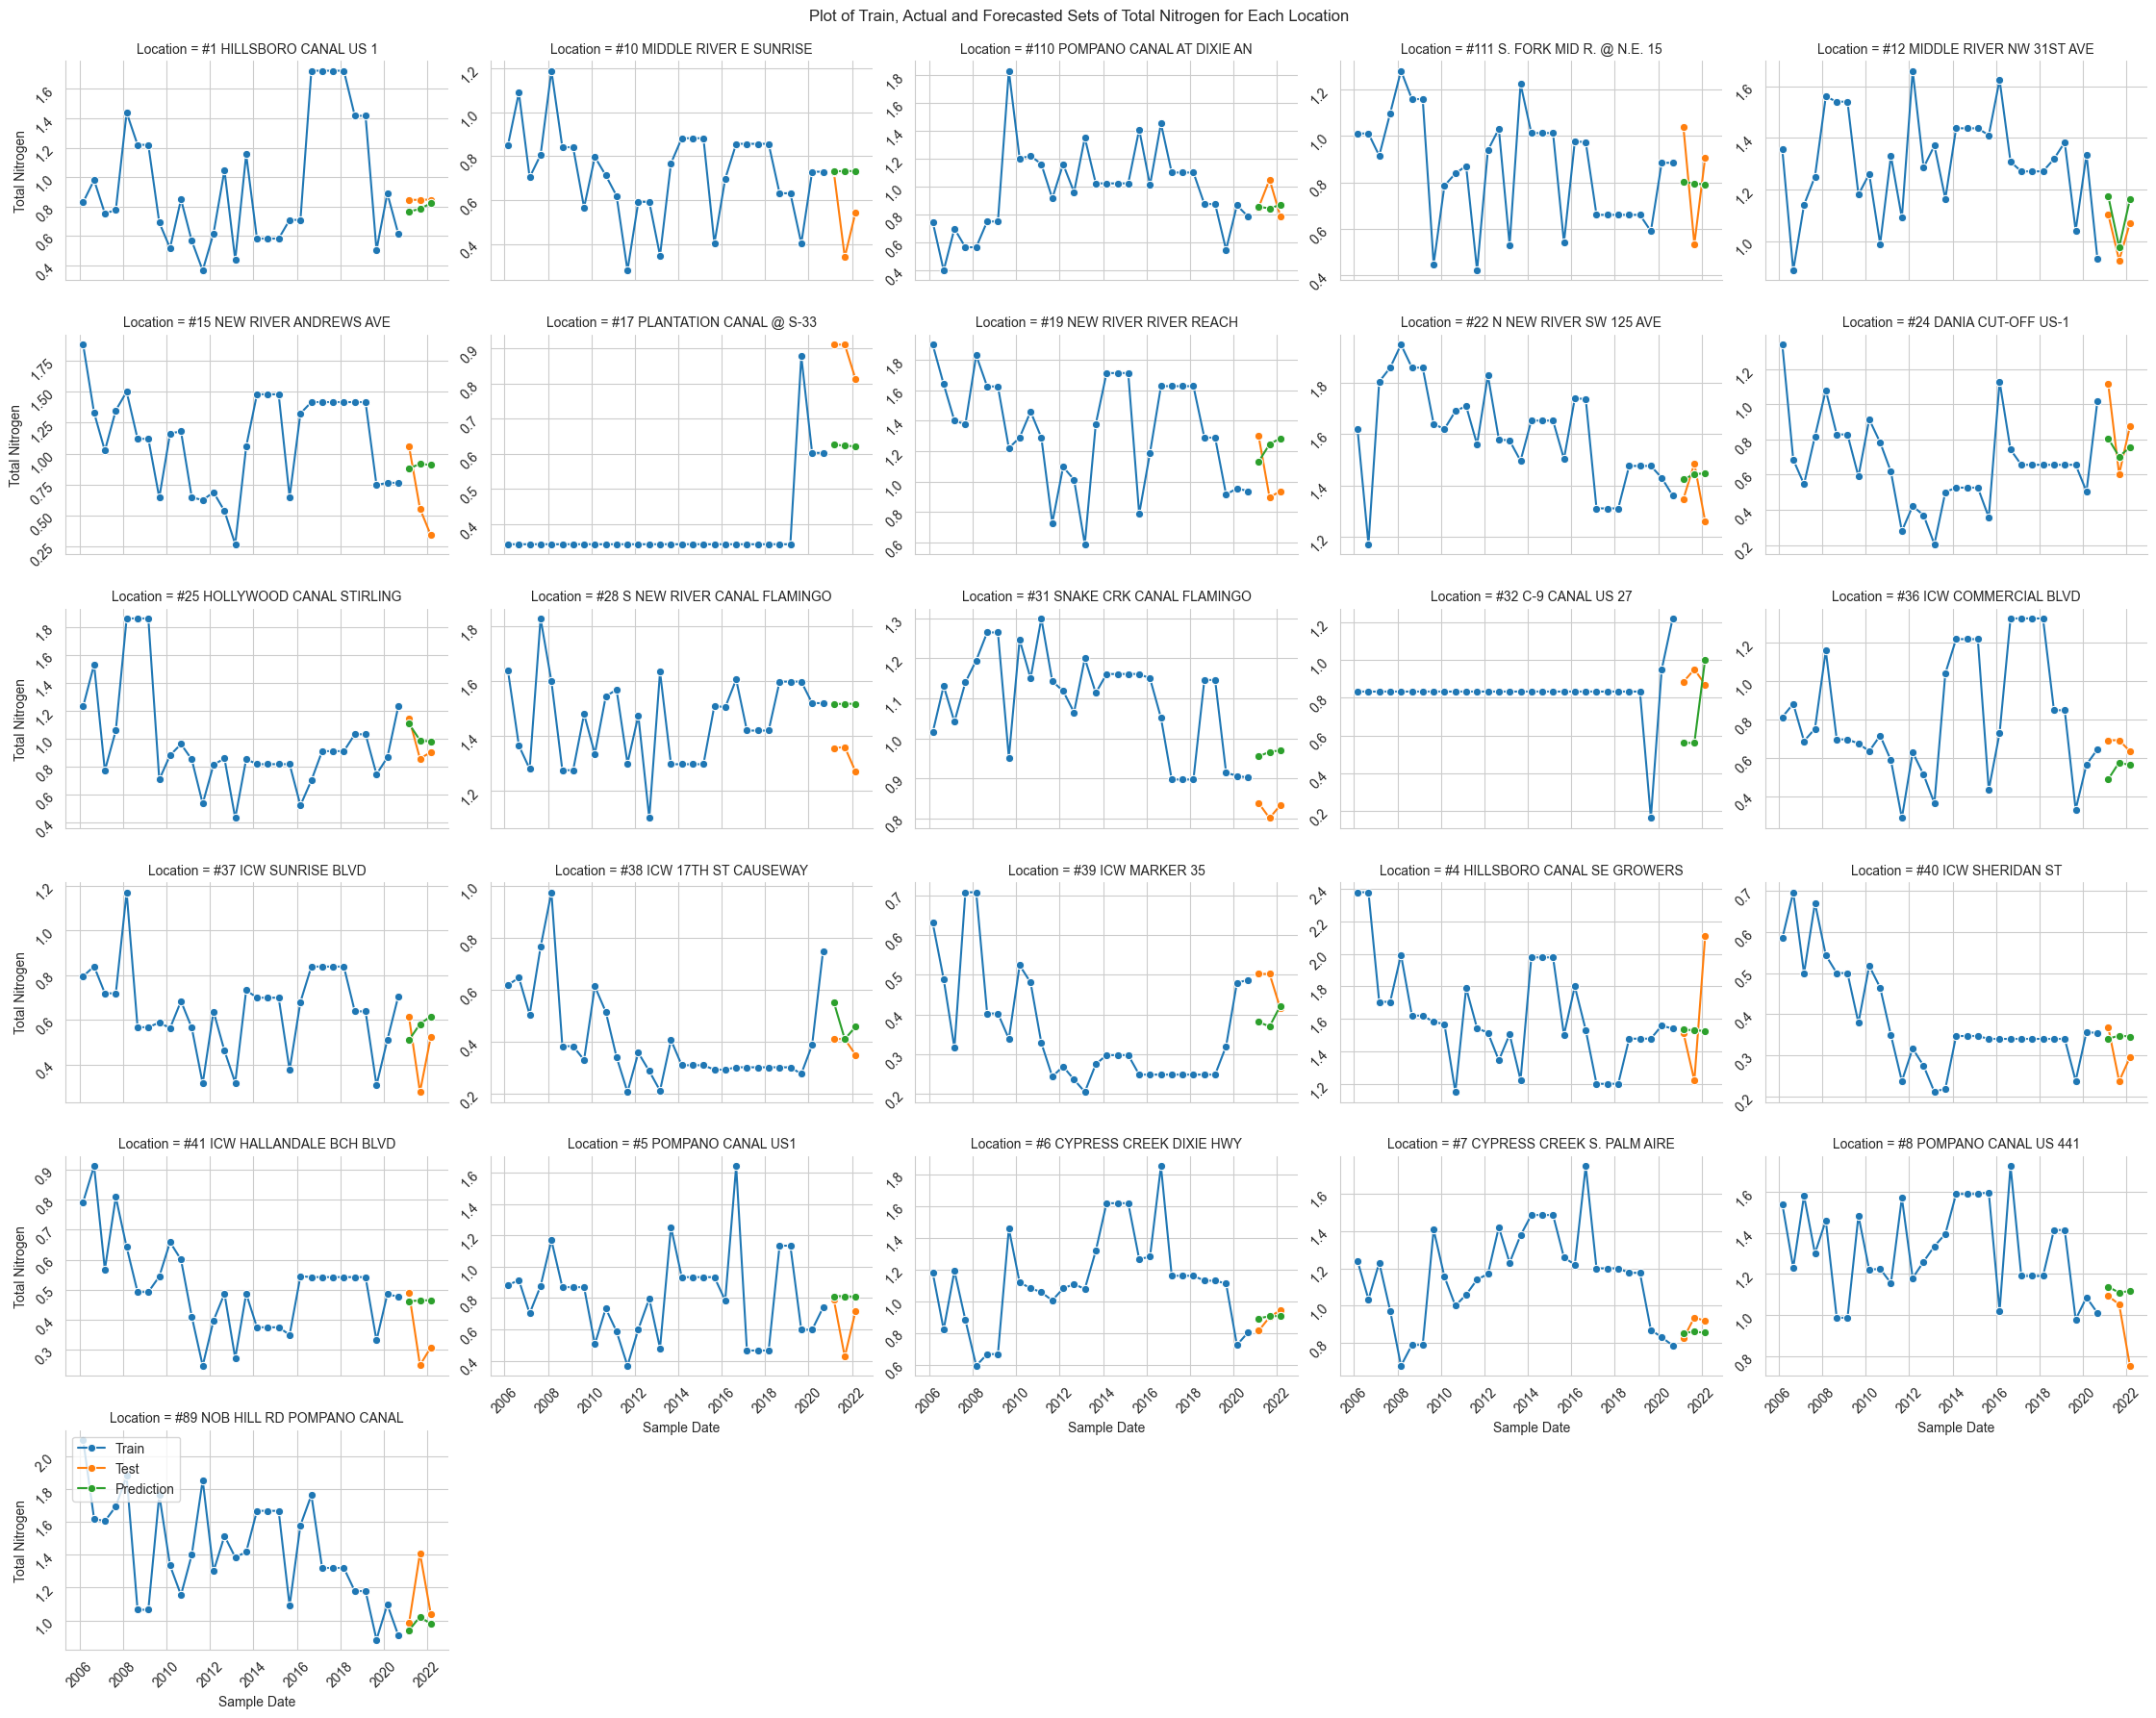

In [32]:
# Convert "Sample Date" to datetime
combined_data["Sample Date"] = pd.to_datetime(combined_data["Sample Date"])

# Determine the maximum and minimum values of param across all locations
param_max = combined_data[param].max()
param_min = combined_data[param].min()

# Create facet plot
plt.figure(figsize=(20, 15))
sns.set_style("whitegrid")
g = sns.FacetGrid(combined_data, col="Location", hue="dataset", col_wrap=5, height=3, aspect=1.5, sharey=False)

# Iterate over each parameter and map them onto the facet grid for both train and test data
line = g.map(sns.lineplot, "Sample Date", param, marker="o")

# Rotate x-axis labels for better readability
for ax in g.axes.ravel():
    ax.tick_params(labelrotation=45)

plt.subplots_adjust(top=0.95)
g.fig.suptitle('Plot of Train, Actual and Forecasted Sets of Total Nitrogen for Each Location')

# Adjust legend
plt.legend(loc='upper left')

plt.show()

In [33]:
maes, mses, rmses = [], [], []
for location in train_data["Location"].unique():
    test_df = test_data[test_data["Location"]==location]
    pred_df = pred_data[pred_data["Location"]==location]
    mae = mean_absolute_error(test_df[param], pred_df[param])
    mse = mean_squared_error(test_df[param], pred_df[param])
    rmse = np.sqrt(mse)

    maes.append(mae)
    mses.append(mse)
    rmses.append(rmse)
accuracy = pd.DataFrame({"Location": train_data["Location"].unique(),
              "MAE": maes,
              "MSE": mses,
              "RMSE": rmses,
            })

In [34]:
accuracy.sort_values(by="RMSE", ascending=False)

Location       MAE       MSE      RMSE
5        #15 NEW RIVER ANDREWS AVE  0.368591  0.160870  0.401086
18   #4 HILLSBORO CANAL SE GROWERS  0.304458  0.145635  0.381622
13             #32 C-9 CANAL US 27  0.281660  0.091156  0.301921
7        #19 NEW RIVER RIVER REACH  0.288318  0.090309  0.300515
6      #17 PLANTATION CANAL @ S-33  0.254452  0.066745  0.258351
1       #10 MIDDLE RIVER E SUNRISE  0.194455  0.063033  0.251063
21            #5 POMPANO CANAL US1  0.166215  0.052612  0.229374
25   #89 NOB HILL RD POMPANO CANAL  0.164096  0.051904  0.227824
24         #8 POMPANO CANAL US 441  0.155398  0.045999  0.214475
3    #111 S. FORK MID R. @ N.E. 15  0.203406  0.045374  0.213011
9           #24 DANIA CUT-OFF US-1  0.176255  0.040197  0.200493
11  #28 S NEW RIVER CANAL FLAMINGO  0.188996  0.037458  0.193541
15            #37 ICW SUNRISE BLVD  0.166034  0.037026  0.192421
20     #41 ICW HALLANDALE BCH BLVD  0.133218  0.023908  0.154622
14         #36 ICW COMMERCIAL BLVD  0.130757  0.020064  0.141648
12    #31 SNAKE CRK CANAL FLAMINGO  0.139724  0.019934  0.141188
2   #110 POMPANO CANAL AT DIXIE AN  0.098026  0.016546  0.128629
8       #22 N NEW RIVER SW 125 AVE  0.102050  0.014272  0.119464
17               #39 ICW MARKER 35  0.086605  0.010694  0.103412
16        #38 ICW 17TH ST CAUSEWAY  0.083166  0.010521  0.102573
10    #25 HOLLYWOOD CANAL STIRLING  0.082179  0.008146  0.090257
4     #12 MIDDLE RIVER NW 31ST AVE  0.071028  0.005314  0.072898
19             #40 ICW SHERIDAN ST  0.063368  0.005238  0.072374
23   #7 CYPRESS CREEK S. PALM AIRE  0.056463  0.003582  0.059847
0          #1 HILLSBORO CANAL US 1  0.055157  0.003565  0.059709
22      #6 CYPRESS CREEK DIXIE HWY  0.040250  0.002495  0.049954

## Total Phosphorus

In [35]:
param = 'Total Phosphorus'

In [36]:
predictions = []
for location in train_data["Location"].unique():
    train_df = train_data[train_data["Location"]==location]
    test_df = test_data[test_data["Location"]==location]

    # Fit ARIMA model
    order = (2, 1, 1)  # Example (p, d, q)
    model = ARIMA(train_df[param], order=order)
    result = model.fit()

    # Forecast future values
    forecast = result.get_forecast(steps=3)  # Forecasting next 3 years (6 biannual periods) into the future
    forecast_index = pd.date_range(start=train_df["Sample Date"].iloc[-1], periods=4, freq='6M')[1:]
    forecast_values = forecast.predicted_mean

    predictions.append(pd.DataFrame({"Location": [location]*3, "Sample Date": forecast_index,param: forecast_values}))
pred_data = pd.concat(predictions)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/var/folders/9n/nyfs9h7n2lsfs0vd2lq0589h0000gn/T/ipykernel_40936/2550153663.py:13: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=train_df["Sample Date"].iloc[-1], periods=4, freq='6M')[1:]
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was pr

In [37]:
# Concatenate train and test data for plotting
combined_data = pd.concat([train_data.assign(dataset='Train'), test_data.assign(dataset='Test'), pred_data.assign(dataset='Prediction')])

<Figure size 2000x1500 with 0 Axes>

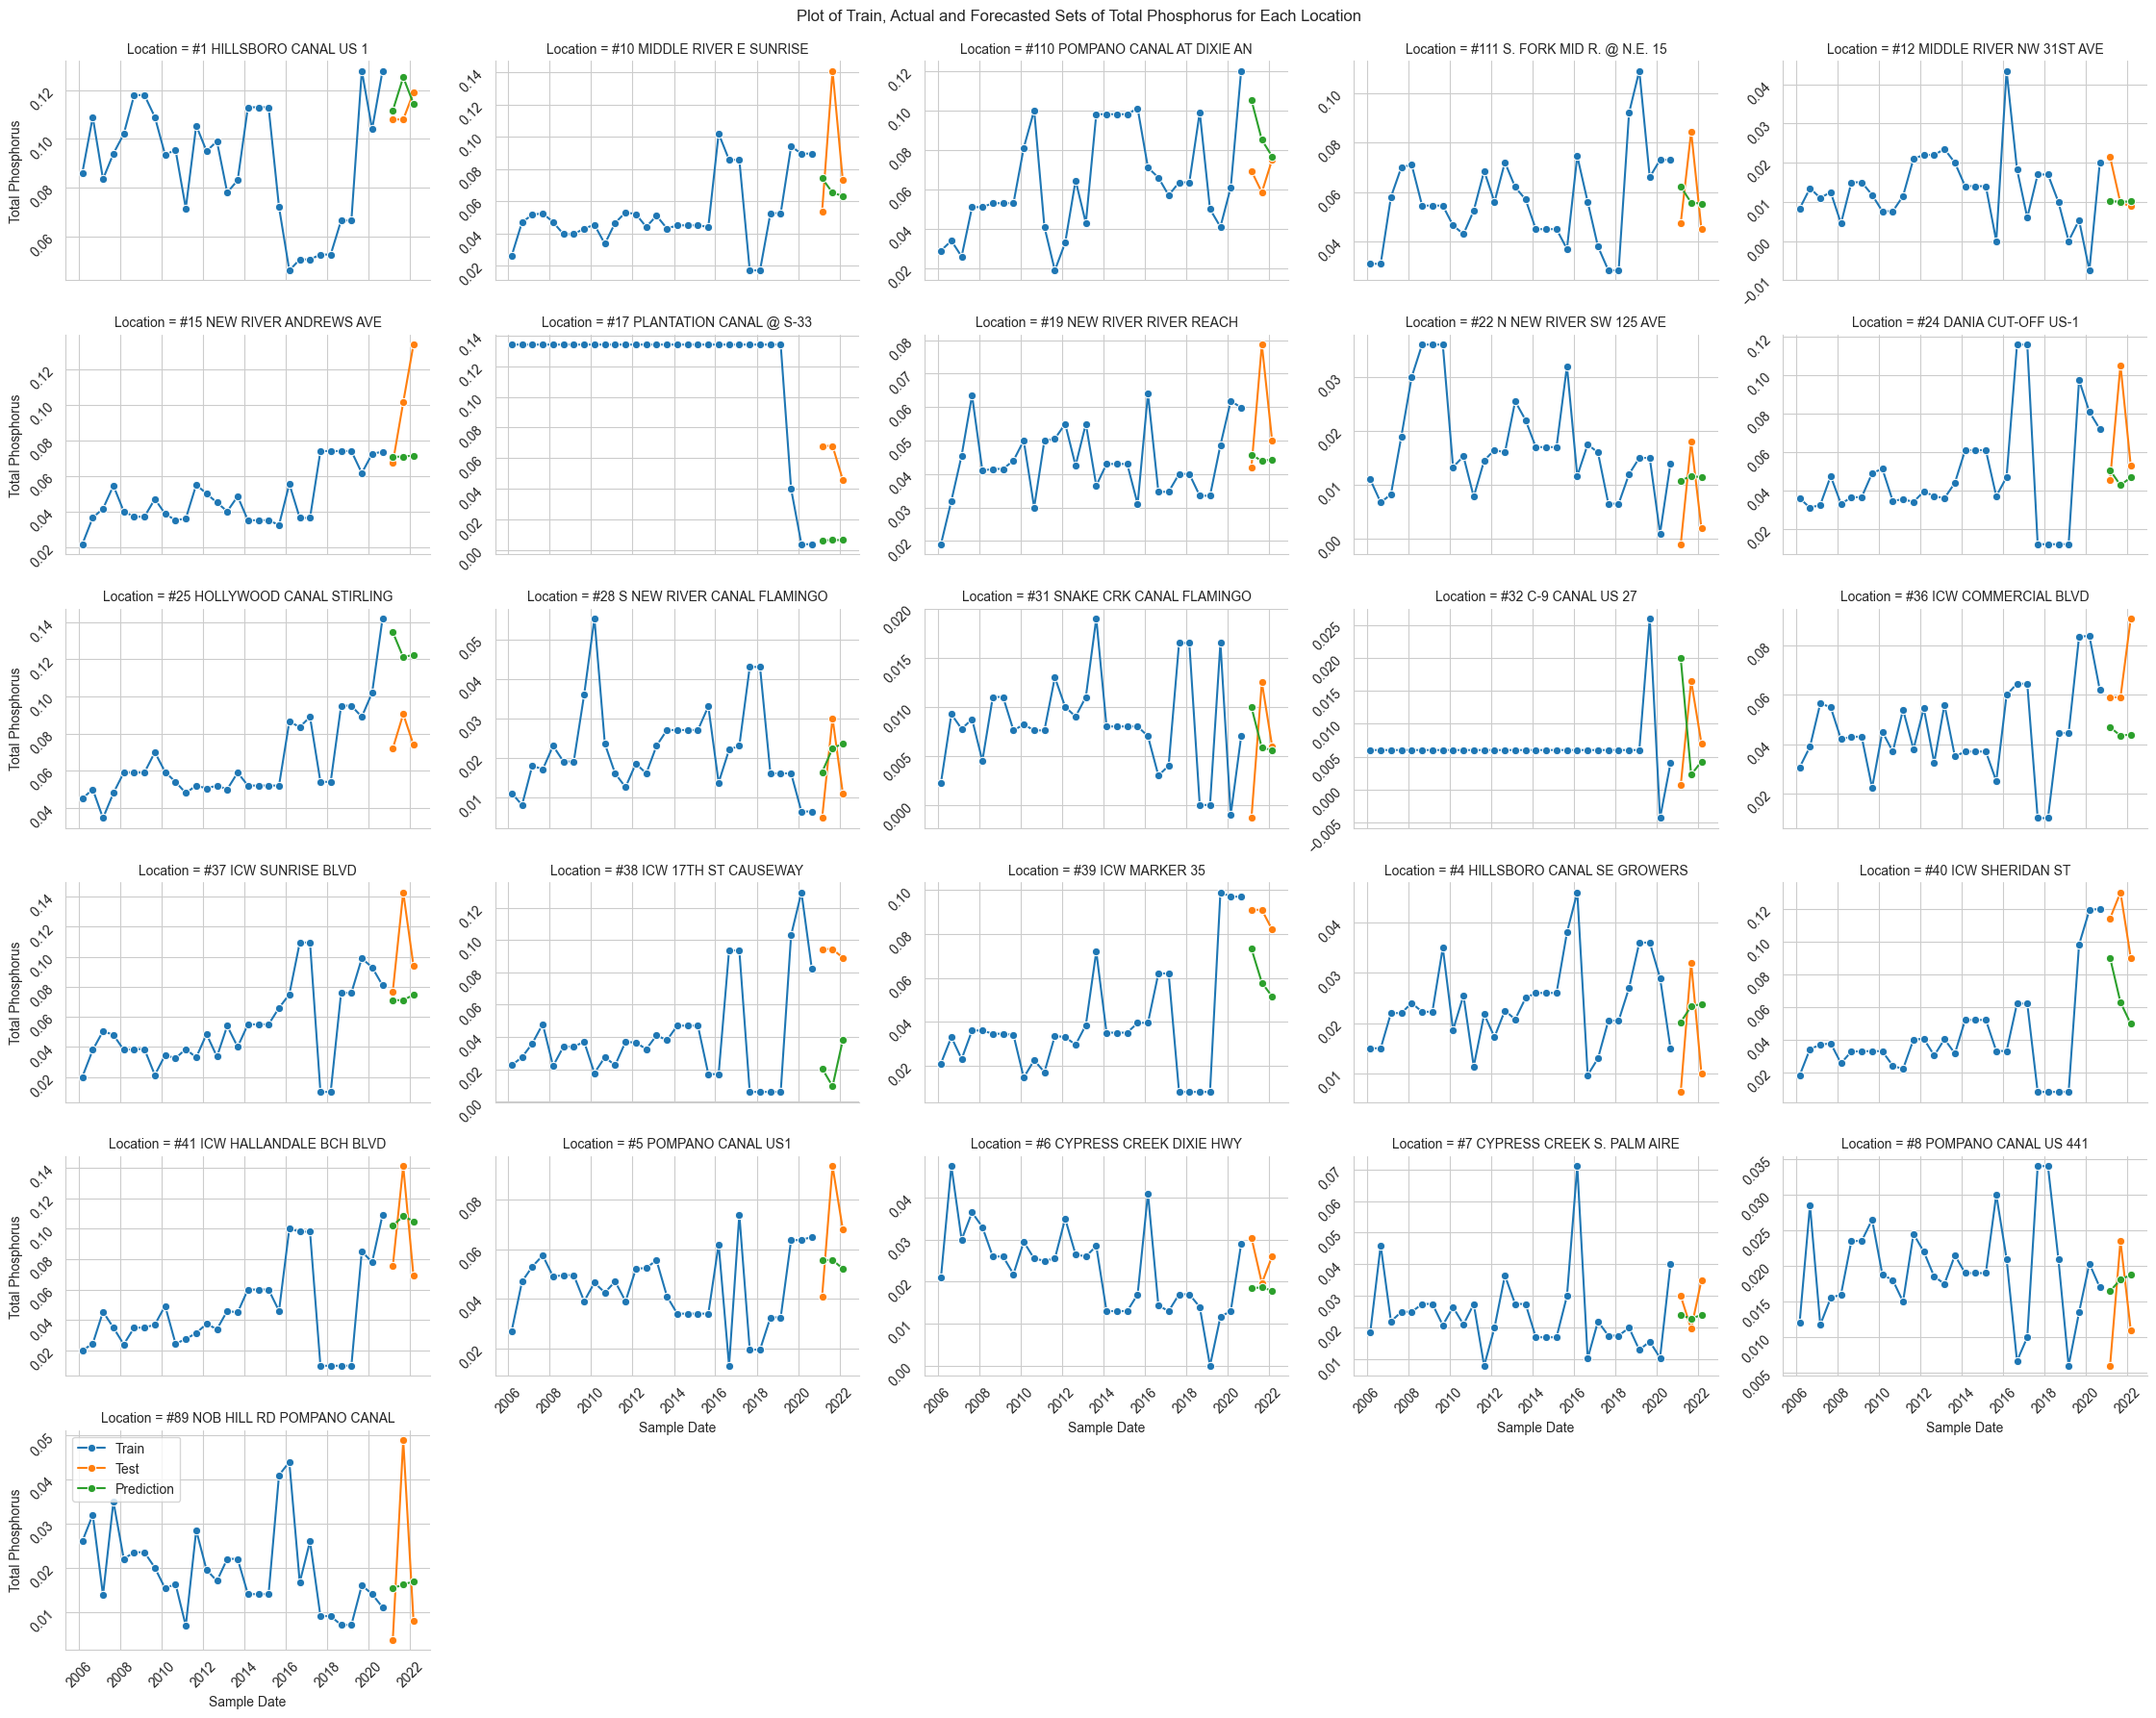

In [38]:
# Convert "Sample Date" to datetime
combined_data["Sample Date"] = pd.to_datetime(combined_data["Sample Date"])

# Determine the maximum and minimum values of param across all locations
param_max = combined_data[param].max()
param_min = combined_data[param].min()

# Create facet plot
plt.figure(figsize=(20, 15))
sns.set_style("whitegrid")
g = sns.FacetGrid(combined_data, col="Location", hue="dataset", col_wrap=5, height=3, aspect=1.5, sharey=False)

# Iterate over each parameter and map them onto the facet grid for both train and test data
line = g.map(sns.lineplot, "Sample Date", param, marker="o")

# Rotate x-axis labels for better readability
for ax in g.axes.ravel():
    ax.tick_params(labelrotation=45)

plt.subplots_adjust(top=0.95)
g.fig.suptitle('Plot of Train, Actual and Forecasted Sets of Total Phosphorus for Each Location')

# Adjust legend
plt.legend(loc='upper left')

plt.show()

In [39]:
maes, mses, rmses = [], [], []
for location in train_data["Location"].unique():
    test_df = test_data[test_data["Location"]==location]
    pred_df = pred_data[pred_data["Location"]==location]
    mae = mean_absolute_error(test_df[param], pred_df[param])
    mse = mean_squared_error(test_df[param], pred_df[param])
    rmse = np.sqrt(mse)

    maes.append(mae)
    mses.append(mse)
    rmses.append(rmse)
accuracy = pd.DataFrame({"Location": train_data["Location"].unique(),
              "MAE": maes,
              "MSE": mses,
              "RMSE": rmses,
            })

In [40]:
accuracy.sort_values(by="RMSE", ascending=False)

Location       MAE       MSE      RMSE
16        #38 ICW 17TH ST CAUSEWAY  0.069866  0.005081  0.071280
6      #17 PLANTATION CANAL @ S-33  0.054045  0.003030  0.055043
10    #25 HOLLYWOOD CANAL STIRLING  0.047223  0.002401  0.049000
19             #40 ICW SHERIDAN ST  0.043863  0.002242  0.047346
1       #10 MIDDLE RIVER E SUNRISE  0.035340  0.002083  0.045639
15            #37 ICW SUNRISE BLVD  0.032344  0.001859  0.043121
5        #15 NEW RIVER ANDREWS AVE  0.032204  0.001619  0.040238
9           #24 DANIA CUT-OFF US-1  0.024611  0.001327  0.036433
20     #41 ICW HALLANDALE BCH BLVD  0.031756  0.001023  0.031989
14         #36 ICW COMMERCIAL BLVD  0.024921  0.000869  0.029473
17               #39 ICW MARKER 35  0.027140  0.000782  0.027968
2   #110 POMPANO CANAL AT DIXIE AN  0.021364  0.000665  0.025779
21            #5 POMPANO CANAL US1  0.022750  0.000631  0.025128
25   #89 NOB HILL RD POMPANO CANAL  0.017811  0.000432  0.020775
7        #19 NEW RIVER RIVER REACH  0.014739  0.000419  0.020465
3    #111 S. FORK MID R. @ N.E. 15  0.017895  0.000381  0.019525
13             #32 C-9 CANAL US 27  0.012086  0.000194  0.013926
18   #4 HILLSBORO CANAL SE GROWERS  0.012112  0.000153  0.012356
11  #28 S NEW RIVER CANAL FLAMINGO  0.010620  0.000117  0.010832
0          #1 HILLSBORO CANAL US 1  0.008498  0.000111  0.010550
8       #22 N NEW RIVER SW 125 AVE  0.009199  0.000090  0.009464
22      #6 CYPRESS CREEK DIXIE HWY  0.007076  0.000071  0.008434
24         #8 POMPANO CANAL US 441  0.007863  0.000066  0.008131
12    #31 SNAKE CRK CANAL FLAMINGO  0.006129  0.000058  0.007588
23   #7 CYPRESS CREEK S. PALM AIRE  0.006698  0.000055  0.007425
4     #12 MIDDLE RIVER NW 31ST AVE  0.004255  0.000043  0.006552

## Turbidity

In [41]:
param = 'Turbidity'

In [42]:
predictions = []
for location in train_data["Location"].unique():
    train_df = train_data[train_data["Location"]==location]
    test_df = test_data[test_data["Location"]==location]

    # Fit ARIMA model
    order = (2, 1, 1)  # Example (p, d, q)
    model = ARIMA(train_df[param], order=order)
    result = model.fit()

    # Forecast future values
    forecast = result.get_forecast(steps=3)  # Forecasting next 3 years (6 biannual periods) into the future
    forecast_index = pd.date_range(start=train_df["Sample Date"].iloc[-1], periods=4, freq='6M')[1:]
    forecast_values = forecast.predicted_mean

    predictions.append(pd.DataFrame({"Location": [location]*3, "Sample Date": forecast_index,param: forecast_values}))
pred_data = pd.concat(predictions)

/var/folders/9n/nyfs9h7n2lsfs0vd2lq0589h0000gn/T/ipykernel_40936/2550153663.py:13: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=train_df["Sample Date"].iloc[-1], periods=4, freq='6M')[1:]
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates,

In [43]:
# Concatenate train and test data for plotting
combined_data = pd.concat([train_data.assign(dataset='Train'), test_data.assign(dataset='Test'), pred_data.assign(dataset='Prediction')])

<Figure size 2000x1500 with 0 Axes>

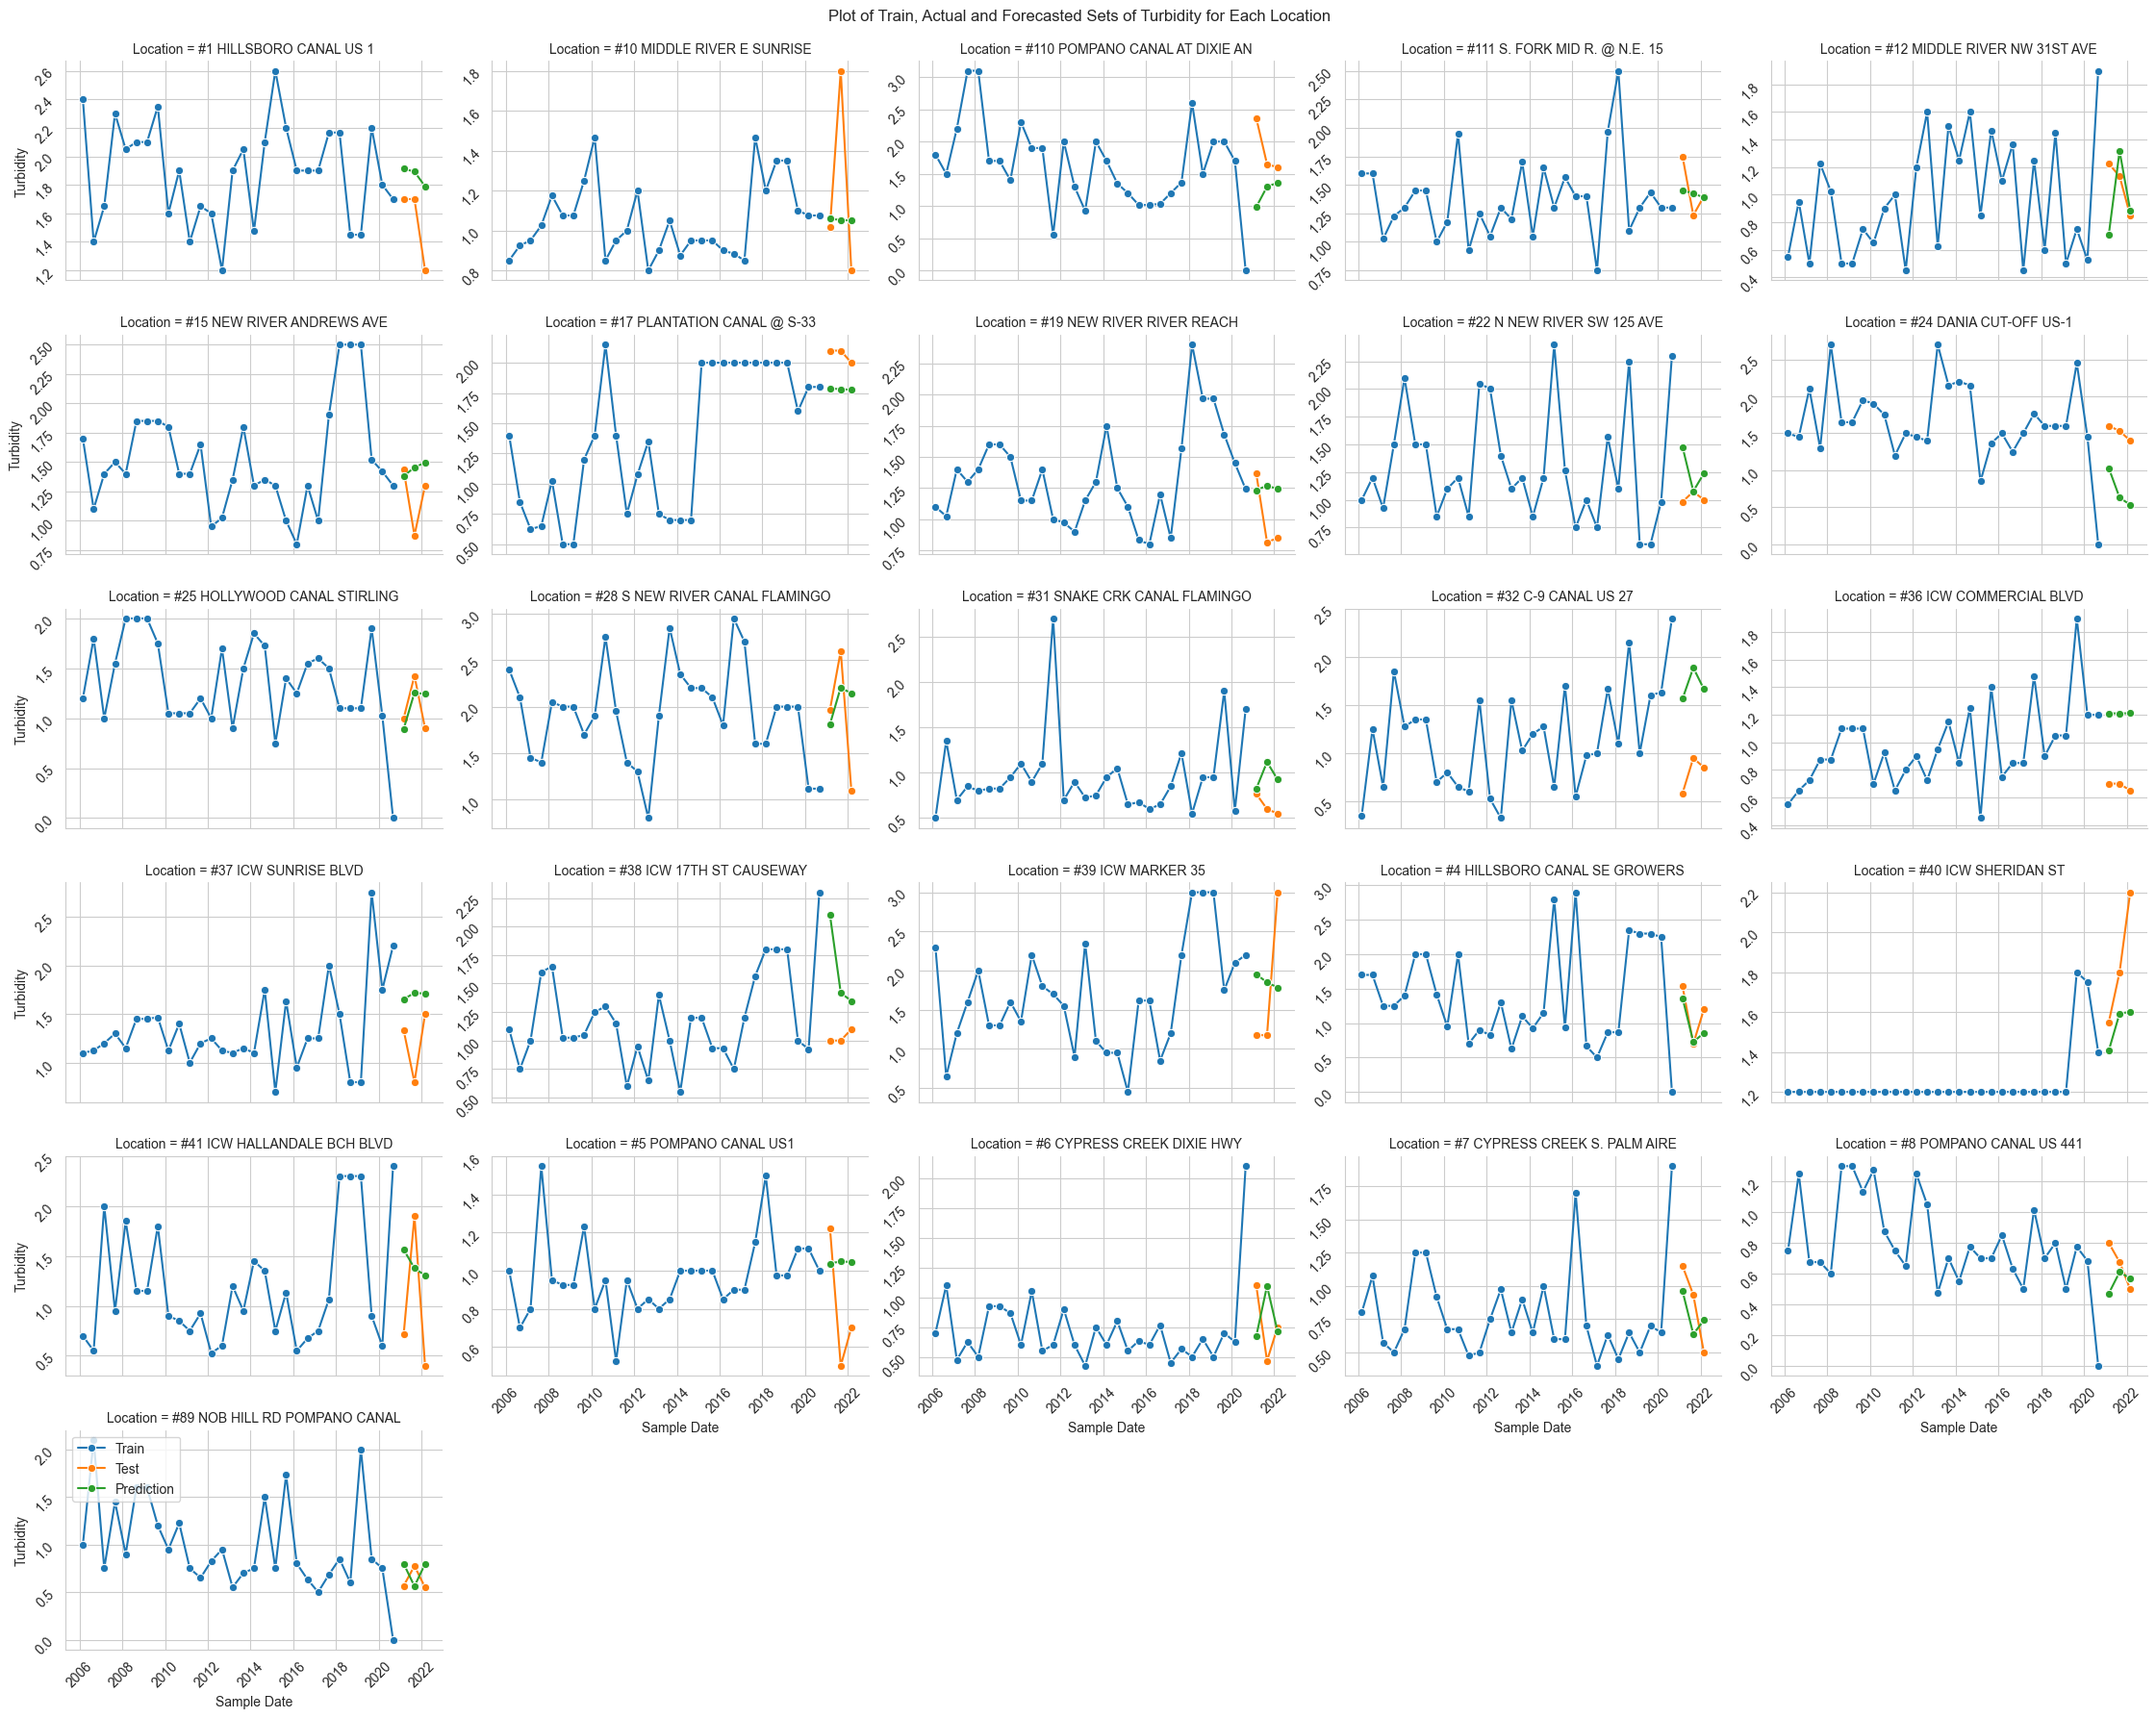

In [44]:
# Convert "Sample Date" to datetime
combined_data["Sample Date"] = pd.to_datetime(combined_data["Sample Date"])

# Determine the maximum and minimum values of param across all locations
param_max = combined_data[param].max()
param_min = combined_data[param].min()

# Create facet plot
plt.figure(figsize=(20, 15))
sns.set_style("whitegrid")
g = sns.FacetGrid(combined_data, col="Location", hue="dataset", col_wrap=5, height=3, aspect=1.5, sharey=False)

# Iterate over each parameter and map them onto the facet grid for both train and test data
line = g.map(sns.lineplot, "Sample Date", param, marker="o")

# Rotate x-axis labels for better readability
for ax in g.axes.ravel():
    ax.tick_params(labelrotation=45)

plt.subplots_adjust(top=0.95)
g.fig.suptitle('Plot of Train, Actual and Forecasted Sets of Turbidity for Each Location')

# Adjust legend
plt.legend(loc='upper left')

plt.show()

In [45]:
maes, mses, rmses = [], [], []
for location in train_data["Location"].unique():
    test_df = test_data[test_data["Location"]==location]
    pred_df = pred_data[pred_data["Location"]==location]
    mae = mean_absolute_error(test_df[param], pred_df[param])
    mse = mean_squared_error(test_df[param], pred_df[param])
    rmse = np.sqrt(mse)

    maes.append(mae)
    mses.append(mse)
    rmses.append(rmse)
accuracy = pd.DataFrame({"Location": train_data["Location"].unique(),
              "MAE": maes,
              "MSE": mses,
              "RMSE": rmses,
            })

In [46]:
accuracy.sort_values(by="RMSE", ascending=False)

Location       MAE       MSE      RMSE
17               #39 ICW MARKER 35  0.889325  0.845991  0.919778
13             #32 C-9 CANAL US 27  0.911604  0.835973  0.914316
2   #110 POMPANO CANAL AT DIXIE AN  0.656972  0.696829  0.834763
9           #24 DANIA CUT-OFF US-1  0.779838  0.630246  0.793880
20     #41 ICW HALLANDALE BCH BLVD  0.758658  0.603899  0.777110
16        #38 ICW 17TH ST CAUSEWAY  0.589049  0.482902  0.694911
11  #28 S NEW RIVER CANAL FLAMINGO  0.529500  0.420274  0.648285
15            #37 ICW SUNRISE BLVD  0.481843  0.328968  0.573557
14         #36 ICW COMMERCIAL BLVD  0.527636  0.278991  0.528196
1       #10 MIDDLE RIVER E SUNRISE  0.346082  0.207427  0.455441
22      #6 CYPRESS CREEK DIXIE HWY  0.364696  0.192870  0.439170
21            #5 POMPANO CANAL US1  0.360433  0.151867  0.389701
0          #1 HILLSBORO CANAL US 1  0.331659  0.143258  0.378495
19             #40 ICW SHERIDAN ST  0.316137  0.140707  0.375109
12    #31 SNAKE CRK CANAL FLAMINGO  0.316524  0.137405  0.370682
7        #19 NEW RIVER RIVER REACH  0.326589  0.125921  0.354854
5        #15 NEW RIVER ANDREWS AVE  0.276014  0.125615  0.354423
8       #22 N NEW RIVER SW 125 AVE  0.245472  0.100436  0.316916
4     #12 MIDDLE RIVER NW 31ST AVE  0.244200  0.099460  0.315373
6      #17 PLANTATION CANAL @ S-33  0.284506  0.082853  0.287842
23   #7 CYPRESS CREEK S. PALM AIRE  0.242446  0.060720  0.246414
25   #89 NOB HILL RD POMPANO CANAL  0.230116  0.053127  0.230494
10    #25 HOLLYWOOD CANAL STIRLING  0.206352  0.052597  0.229341
18   #4 HILLSBORO CANAL SE GROWERS  0.179982  0.049272  0.221972
3    #111 S. FORK MID R. @ N.E. 15  0.167517  0.042069  0.205107
24         #8 POMPANO CANAL US 441  0.153951  0.038956  0.197372